# Bidirectional trajectories of stroke and psychosis: A 16-year longitudinal population study of older adults

## Analysis with missing data imputation

This notebook repeats the Cox proportional hazards regression analyses from Richards-Belle et al but with missing demographics imputed using the missForest package that uses iterated random forests to impute missing data. It also adds sex and age stratified analyses.

The notebook requires the file waves12345.rda which is an R data file containing dataframes generated by the Stroke_Psychosis_ELSA_Pre-processing.R script that processes the original ELSA datafiles. It is available in the same github repository as this notebook: https://github.com/vaughanbell/stroke-psychosis-bidirectional-trajectory

The notebook recodes variables for missing data imputation, imputes a dataset, then completes the analysis for stroke in the psychosis population, then psychosis in the stroke population.

Note: the missing data imputation is computationally intensive and this takes approximately 15-25 minutes to run on a Intel i7-6700.

In [97]:
library(dplyr)
library(survival)
library(survminer)
library(forestmodel)
library(missForest)
library(doParallel)
library(doRNG)

Load pre-processed dataframe created by Stroke_Psychosis_ELSA_Pre-processing.R

In [2]:
transformed_data_dir = "/home/main/data/StrokePsychosisELSATransformedData/"
transformed_data_filename = paste(transformed_data_dir, "waves12345.rda", sep="")

load(file = transformed_data_filename)

#### Recode and arrange data for strokeinpsychosis_surv dataframe

In [3]:
strokeinpsychosis_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

# Get data into right format
strokeinpsychosis_surv$wavefirstparticipate <- as.numeric(strokeinpsychosis_surv$wavefirstparticipate)
strokeinpsychosis_surv$wavelastparticipate <- as.numeric(strokeinpsychosis_surv$wavelastparticipate)
strokeinpsychosis_surv$wavefirstreport_stroke <- as.numeric(strokeinpsychosis_surv$wavefirstreport_stroke)
strokeinpsychosis_surv$wavefirstreport_psychosis <- as.numeric(strokeinpsychosis_surv$wavefirstreport_psychosis)
strokeinpsychosis_surv$strokeever <- as.numeric(strokeinpsychosis_surv$strokeever)
strokeinpsychosis_surv$psychosisever <- as.numeric(strokeinpsychosis_surv$psychosisever)
strokeinpsychosis_surv$netwealth_q5 <- factor(strokeinpsychosis_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

# Assign numeric labels to categorical variables (reference group == 1 i.e. the most healthy level of the variable). 
# If the categories are used then results are not shown in an order than makes sense.

# Vigorous physical activity
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "one to three times a month"] <- 3
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "once a week"] <- 2
strokeinpsychosis_surv$vigorousactbaseline[strokeinpsychosis_surv$vigorousactbaseline == "more than once a week"] <- 1

# Alcohol use
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "1-4 times/week"] <- 5
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Daily/almost daily"] <- 4
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Monthly"] <- 3
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2
strokeinpsychosis_surv$alcoholbaseline[strokeinpsychosis_surv$alcoholbaseline == "Not at all"] <- 1

# Rename variables with more print appropriate names (these appear directly on the forest plot)
strokeinpsychosis_surv <- strokeinpsychosis_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         `Psychosis status` = psychosisever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

# First, account for strokes reported in wave 0 e.g. wave 0.5 (0 is already used to mean no stroke). 
# Where first reported stroke is 0.5, use 0.5 as first wave, otherwise use 'wavefirstparticipate'.
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(wavefirstparticipate = case_when(wavefirstreport_stroke == 0.5 ~ 0.5,
                                          TRUE ~ wavefirstparticipate))

# Create follow-up time variables
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavelastparticipate - wavefirstreport_psychosis, #psychosis but no stroke, f-up starts from report of psychosis to last wave participated
                              psychosisever == 0 & strokeever == 1 ~ wavefirstreport_stroke - wavefirstparticipate, #stroke but no psychosis, f-up starts from wave first participated until stroke is reported
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_stroke > 0 & wavefirstreport_stroke < wavefirstreport_psychosis ~ 0, #if first stroke happened prior to report of psychosis, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_stroke - wavefirstreport_psychosis, #psychosis and stroke, f-up starts from report of psychosis until stroke is reported
                              TRUE ~ 999)) # no 999s appear so everyone has been coded as per the above

# Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
strokeinpsychosis_surv <- strokeinpsychosis_surv %>%
  mutate(fuptime = fuptime * 2)

#### Recode and arrange data for psychosisinstroke_surv dataframe

In [4]:
psychosisinstroke_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

# Get data into right format
psychosisinstroke_surv$wavefirstparticipate <- as.numeric(psychosisinstroke_surv$wavefirstparticipate)
psychosisinstroke_surv$wavelastparticipate <- as.numeric(psychosisinstroke_surv$wavelastparticipate)
psychosisinstroke_surv$wavefirstreport_stroke <- as.numeric(psychosisinstroke_surv$wavefirstreport_stroke)
psychosisinstroke_surv$wavefirstreport_psychosis <- as.numeric(psychosisinstroke_surv$wavefirstreport_psychosis)
psychosisinstroke_surv$strokeever <- as.numeric(psychosisinstroke_surv$strokeever)
psychosisinstroke_surv$psychosisever <- as.numeric(psychosisinstroke_surv$psychosisever)
psychosisinstroke_surv$netwealth_q5 <- factor(psychosisinstroke_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

# Assign numeric labels to cateogrical variables (reference group == 1 i.e. the most healthy level of the variable). 
# If the categories are used then results are not shown in an order than makes sense.

# Vigorous physical activity
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "one to three times a month"] <- 3
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "once a week"] <- 2
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "more than once a week"] <- 1

# Alcohol use
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "1-4 times/week"] <- 5
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Daily/almost daily"] <- 4
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Monthly"] <- 3
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Not at all"] <- 1

# Rename variables with more print appropriate names (these appear directly on the forest plot/outputs)
psychosisinstroke_surv <- psychosisinstroke_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

#Create follow-up time variables
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavefirstreport_psychosis - wavefirstparticipate, #psychosis but no stroke, f-up starts from wave first participated until first report of psychosis
                              psychosisever == 0 & strokeever == 1 ~ wavelastparticipate - wavefirstreport_stroke, #stroke but no psychosis, f-up starts from wave stroke first reported until wave last participated
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_psychosis > 0 & wavefirstreport_psychosis < wavefirstreport_stroke ~ 0, #if first psychosis report happened prior to report of stroke, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_psychosis - wavefirstreport_stroke, #psychosis and stroke, f-up starts from first report of stroke until psychosis is reported
                              TRUE ~ 999))      

# Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = fuptime * 2)

#### Select variables from waves12345 file for inclusion in imputation model

Because we are imputing demographic variables which are common to both strokeinpsychosis_surv and psychosisinstroke_surv dataframes, we only have to do this for one dataframe and can use the imputed demographic variables with the other later on.

In [5]:
strokeinpsychosis_imp <- waves12345 %>%
  select(idauniq, netwealth_q5, alcoholbaseline, smokingbaseline, vigorousactbaseline, w1age, sex, region, ethnicgroup)

Recode key variables and create dataframe for imputation

In [6]:
# Convert characters into factors
strokeinpsychosis_imp$netwealth_q5 <- as.factor(strokeinpsychosis_imp$netwealth_q5)
strokeinpsychosis_imp$alcoholbaseline <- as.factor(strokeinpsychosis_imp$alcoholbaseline)
strokeinpsychosis_imp$smokingbaseline <- as.factor(strokeinpsychosis_imp$smokingbaseline)
strokeinpsychosis_imp$vigorousactbaseline <- as.factor(strokeinpsychosis_imp$vigorousactbaseline)
strokeinpsychosis_imp$sex <- as.factor(strokeinpsychosis_imp$sex)
strokeinpsychosis_imp$region <- as.factor(strokeinpsychosis_imp$region)
strokeinpsychosis_imp$ethnicgroup <- as.factor(strokeinpsychosis_imp$ethnicgroup)

# Change 'unknown' ethnicities to NA
strokeinpsychosis_imp$ethnicgroup[strokeinpsychosis_imp$ethnicgroup == "Unknown"] <- NA

# Make sure format of data is a data frame (required for missForest to run)
strokeinpsychosis_imp <- as.data.frame(strokeinpsychosis_imp)

### Run the missForest function to carry out the imputation process

This the main imputation command, takes some time to run.

Run as parallel proceessing to speed it up as much as possible on multi-core CPUs.

In [7]:
# Register parallel process with doParallel
registerDoParallel()

# Set seed for reproducibility
registerDoRNG(seed = 123)

# Record start time
start_time <- Sys.time()

# Impute
data.imp <- missForest(xmis = strokeinpsychosis_imp, parallelize = "forests")

# Record end time
end_time <- Sys.time()

# Report time duration of missForest imputation
end_time - start_time

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 6 in progress...done!
  missForest iteration 7 in progress...done!
  missForest iteration 8 in progress...done!
  missForest iteration 9 in progress...done!
  missForest iteration 10 in progress...done!


Time difference of 16.99685 mins

In [8]:
# Check normalized root mean squared error
data.imp$OOBerror

# Create data frame with imputed data
imputeddata <- data.imp$ximp

NRMSE          PFC 
3.738074e-05 4.185051e-01

#### Create the fully imputed datasets for survival analysis

First, for the stroke in the psychosis population survival analyses

In [9]:
# Pull out other variables needed for this survival analysis
strokeinpsychosis_variables <- strokeinpsychosis_surv %>%
  select(idauniq, strokeever, psychosisever, fuptime, age_cat)

# Merge imputed data with newly created data frame above
strokeinpsychosis_imp <- merge(strokeinpsychosis_variables, imputeddata, by="idauniq", all.x = TRUE) # all.y keeps unmatched records in the second file, all.x would keep all unmatched records from first file.

Second, for the psychosis in the stroke population survival analyses

In [10]:
# Create new data frame for this survival analysis
psychosisinstroke_imp <- strokeinpsychosis_imp

# Remove stroke in psychosis f-up time variable
psychosisinstroke_imp$fuptime <- NULL

# Merge in psychosis in stroke f-up time variable 
psychosisinstroke_variables <- psychosisinstroke_surv %>%
  select(idauniq, fuptime)

psychosisinstroke_imp <- merge(psychosisinstroke_variables, psychosisinstroke_imp, by="idauniq", all.x = TRUE) # all.y keeps unmatched records in the second file, all.x would keep all unmatched records from first file.

In [11]:
psychosisinstroke_imp$netwealth_q5 <- factor(psychosisinstroke_imp$netwealth_q5, levels = c(5, 4, 3, 2, 1))
strokeinpsychosis_imp$netwealth_q5 <- factor(strokeinpsychosis_imp$netwealth_q5, levels = c(5, 4, 3, 2, 1))

## Stroke in the psychosis population survival analyses

### Cox proportional hazards regression models

#### Adjusted, model 1 (demographic covariates) with imputed data

In [12]:
# Fit model
strokeinpsychosis_coxadjimputed <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp
)

summary(strokeinpsychosis_coxadjimputed)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp)

  n= 19808, number of events= 1462 

                     coef     se(coef) se2      Chisq   DF   p       
psychosisever         1.22546 0.235111 0.209770   27.17    1  1.9e-07
w1age                 0.07217 0.002476 0.002324  849.85    1 7.8e-187
sexFemale            -0.33450 0.057096 0.053029   34.32    1  4.7e-09
ethnicgroupNon-White  0.09300 0.158964 0.148247    0.34    1  5.6e-01
ethnicgroupUnknown            0.000000 0.000000            1         
netwealth_q54         0.06177 0.098934 0.093318    0.39    1  5.3e-01
netwealth_q53         0.35725 0.094471 0.088414   14.30    1  1.6e-04
netwealth_q52         0.51610 0.092988 0.086701   30.80    1  2.9e-08
netwealth_q51         0.76007 0.091067 0.085162   69.66    1  7.0e-17
frailty(idauniq)                                1563.13 1598  7.3e-01

              

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


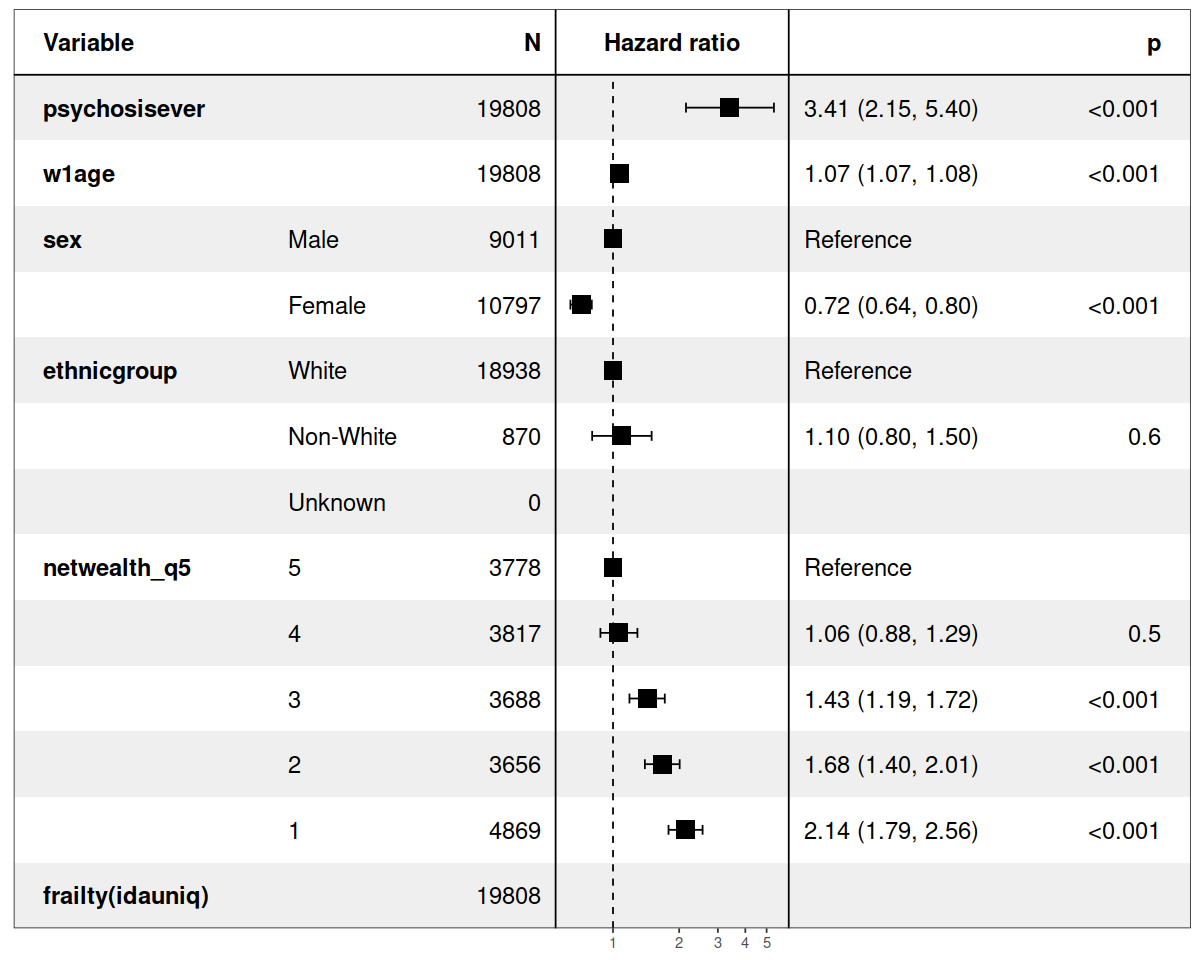

In [13]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadjimputed)

#### Adjusted, model 2 (demographic and health behaviour covariates) with imputed data

In [14]:
# Fit model
strokeinpsychosis_coxadj2imputed <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp
)

summary(strokeinpsychosis_coxadj2imputed)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp)

  n= 19808, number of events= 1462 

                          coef      se(coef) se2      Chisq   DF   p       
psychosisever              1.169795 0.248173 0.212557   22.22    1  2.4e-06
w1age                      0.071327 0.002717 0.002491  689.36    1 6.2e-152
sexFemale                 -0.425544 0.061433 0.055218   47.98    1  4.3e-12
ethnicgroupNon-White      -0.023187 0.167651 0.151504    0.02    1  8.9e-01
ethnicgroupUnknown                  0.000000 0.000000            1         
netwealth_q54              0.014203 0.102821 0.094094    0.02    1  8.9e-01
netwealth_q53              0.280552 0.099387 0.090018    7.97    1  4.8e-03
netwealth_q52              0.386683 0.099036 0.089264   15.24    1  9.4e-05
netwealth_q51              0.548356 0.

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


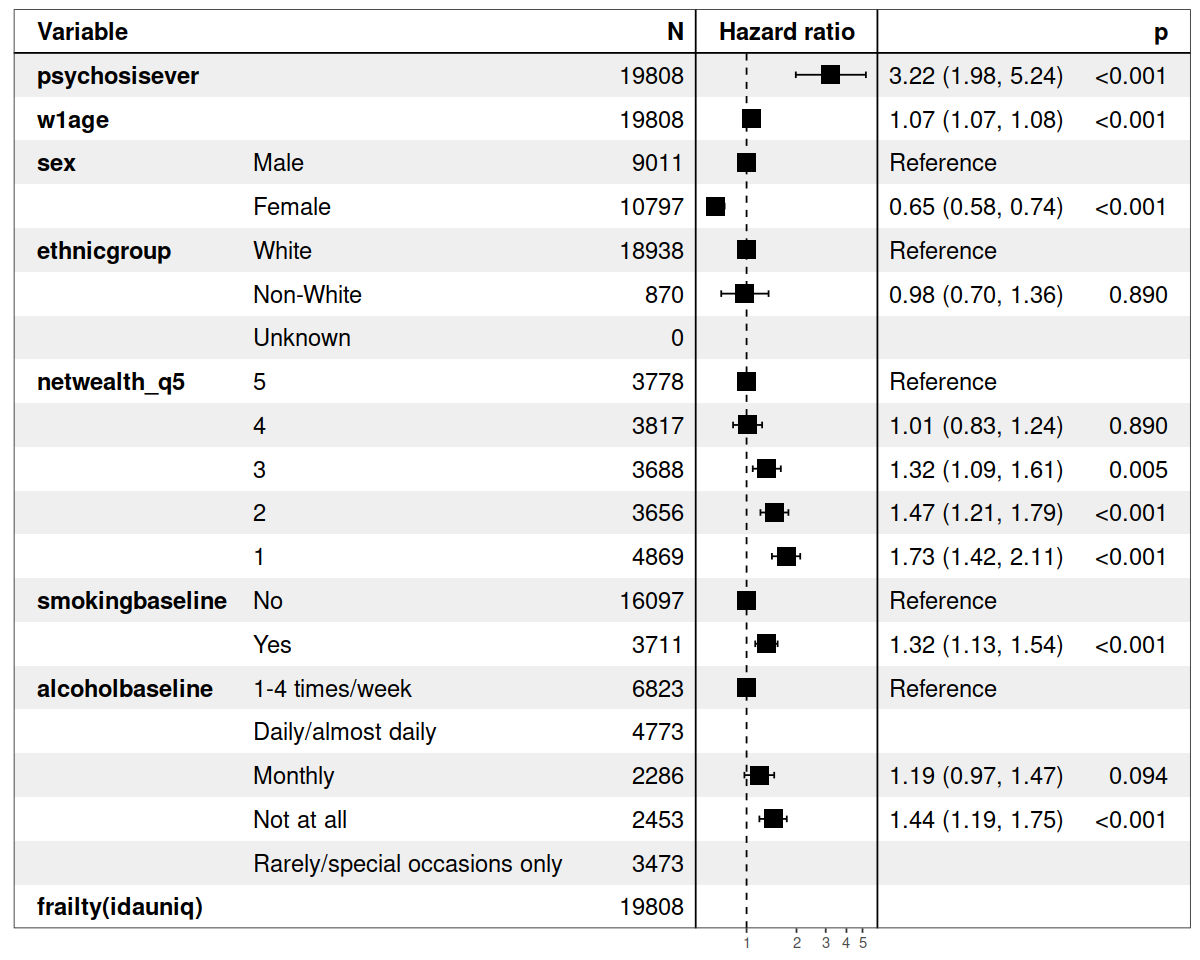

In [15]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputed)

### Sex stratified analysis

#### Females only

In [16]:
strokeinpsychosis_imp_female <- strokeinpsychosis_imp %>%
  filter(sex == "Female")

#### Females, unadjusted with imputed data

In [17]:
psychosisinstroke_coximputedfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = strokeinpsychosis_imp_female
)

summary(psychosisinstroke_coximputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = strokeinpsychosis_imp_female)

  n= 10797, number of events= 96 

            coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 1.558     4.748    0.271 5.747 9.07e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     4.748     0.2106     2.791     8.077

Concordance= 0.593  (se = 0.025 )
Likelihood ratio test= 23.74  on 1 df,   p=1e-06
Wald test            = 33.03  on 1 df,   p=9e-09
Score (logrank) test = 40.18  on 1 df,   p=2e-10


Resized limits to included dashed line in forest panel



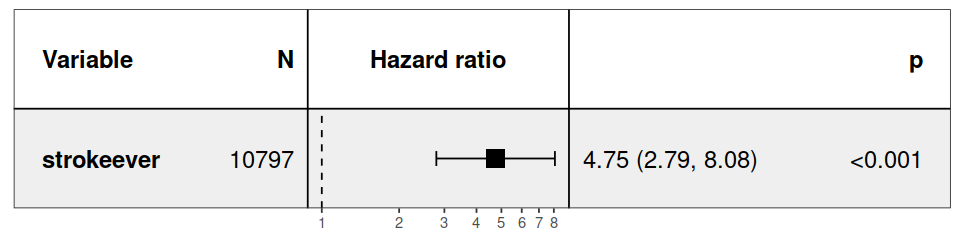

In [18]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedfemale)

#### Females adjusted, model 1 (demographic covariates) with imputed data

In [19]:
# Fit model
strokeinpsychosis_coxadjimputedfemale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_female
)

summary(strokeinpsychosis_coxadjimputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_female)

  n= 10797, number of events= 725 

                     coef     se(coef) se2      Chisq  DF    p      
psychosisever         1.43537 0.278799 0.249748  26.51   1.0 2.6e-07
w1age                 0.06997 0.003338 0.003178 439.32   1.0 1.5e-97
sexFemale                     0.000000 0.000000          1.0        
ethnicgroupNon-White  0.08349 0.236323 0.225278   0.12   1.0 7.2e-01
ethnicgroupUnknown            0.000000 0.000000          1.0        
netwealth_q54        -0.07888 0.147988 0.142065   0.28   1.0 5.9e-01
netwealth_q53         0.37572 0.135414 0.128909   7.70   1.0 5.5e-03
netwealth_q52         0.48536 0.132132 0.125415  13.49   1.0 2.4e-04
netwealth_q51         0.66274 0.131149 0.124830  25.54   1.0 4.3e-07
frailty(idauniq)                                631.19 641.2 6.0e-01

                   

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


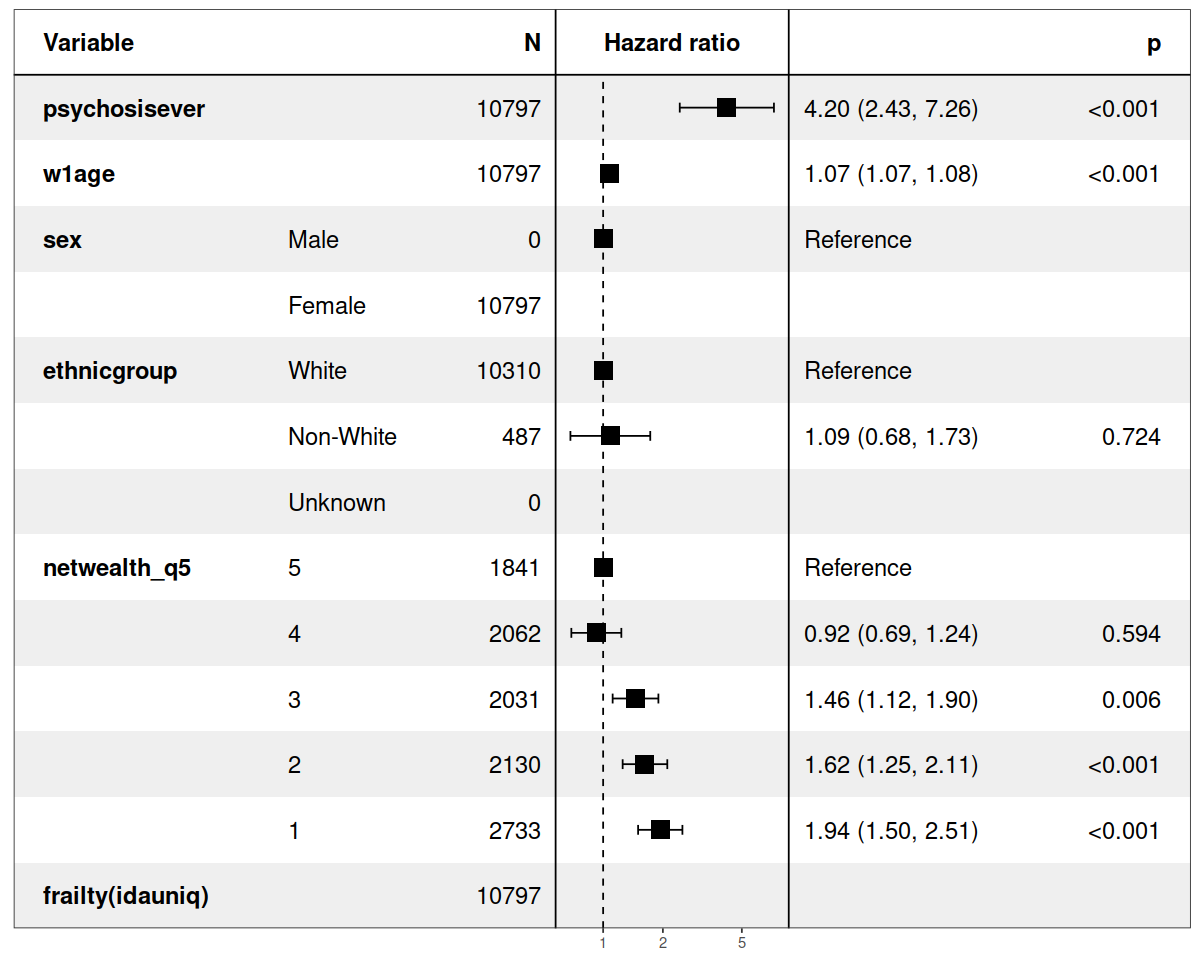

In [20]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadjimputedfemale)

#### Females adjusted model 2 (with demographic and health behaviour covariates)

In [21]:
strokeinpsychosis_coxadj2imputedfemale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_female
)

summary(strokeinpsychosis_coxadj2imputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_female)

  n= 10797, number of events= 725 

                          coef     se(coef) se2      Chisq   DF   p      
psychosisever              1.39958 0.304112 0.255339   21.18    1 4.2e-06
w1age                      0.06861 0.003747 0.003452  335.19    1 7.1e-75
sexFemale                          0.000000 0.000000            1        
ethnicgroupNon-White      -0.01406 0.252189 0.231171    0.00    1 9.6e-01
ethnicgroupUnknown                 0.000000 0.000000            1        
netwealth_q54             -0.15583 0.155262 0.143312    1.01    1 3.2e-01
netwealth_q53              0.27366 0.144454 0.131529    3.59    1 5.8e-02
netwealth_q52              0.34042 0.142643 0.129323    5.70    1 1.7e-02
netwealth_q51              0.40181 0.145929 0.1327

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


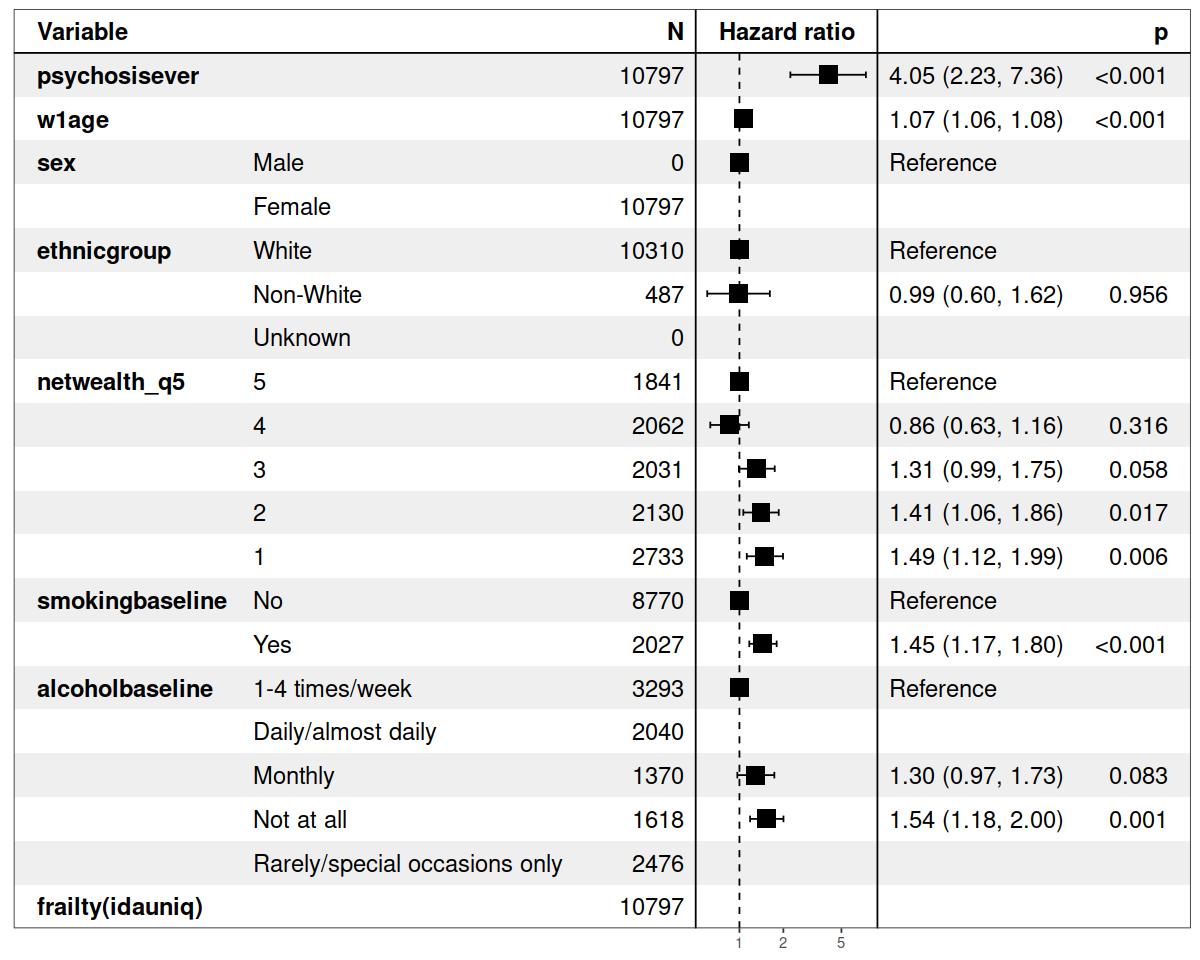

In [22]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputedfemale)

#### Males only

In [23]:
strokeinpsychosis_imp_male <- strokeinpsychosis_imp %>%
  filter(sex == "Male")

#### Males, unadjusted with imputed data

In [24]:
psychosisinstroke_coximputedmale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = strokeinpsychosis_imp_male
)

summary(psychosisinstroke_coximputedmale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 66 

             coef exp(coef) se(coef)     z Pr(>|z|)
strokeever 0.6390    1.8946   0.4022 1.589    0.112

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     1.895     0.5278    0.8613     4.168

Concordance= 0.531  (se = 0.023 )
Likelihood ratio test= 2.15  on 1 df,   p=0.1
Wald test            = 2.52  on 1 df,   p=0.1
Score (logrank) test = 2.61  on 1 df,   p=0.1


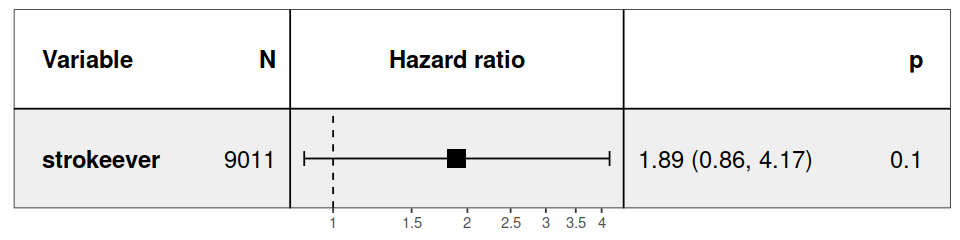

In [25]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedmale)

#### Males adjusted, model 1 (demographic covariates) with imputed data

In [26]:
strokeinpsychosis_coxadjimputedmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_male
)

summary(strokeinpsychosis_coxadjimputedmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 737 

                     coef    se(coef) se2      Chisq   DF   p      
psychosisever        0.84147 0.441408 0.388542    3.63    1 5.7e-02
w1age                0.07691 0.003831 0.003481  402.90    1 1.3e-89
sexFemale                    0.000000 0.000000            1        
ethnicgroupNon-White 0.10400 0.224200 0.198799    0.22    1 6.4e-01
ethnicgroupUnknown           0.000000 0.000000            1        
netwealth_q54        0.18826 0.137740 0.124340    1.87    1 1.7e-01
netwealth_q53        0.33833 0.137070 0.122897    6.09    1 1.4e-02
netwealth_q52        0.55456 0.136757 0.121839   16.44    1 5.0e-05
netwealth_q51        0.90672 0.131787 0.117959   47.34    1 6.0e-12
frailty(idauniq)                               1216.38 1272 8.6e-01

                     exp(coef) ex

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


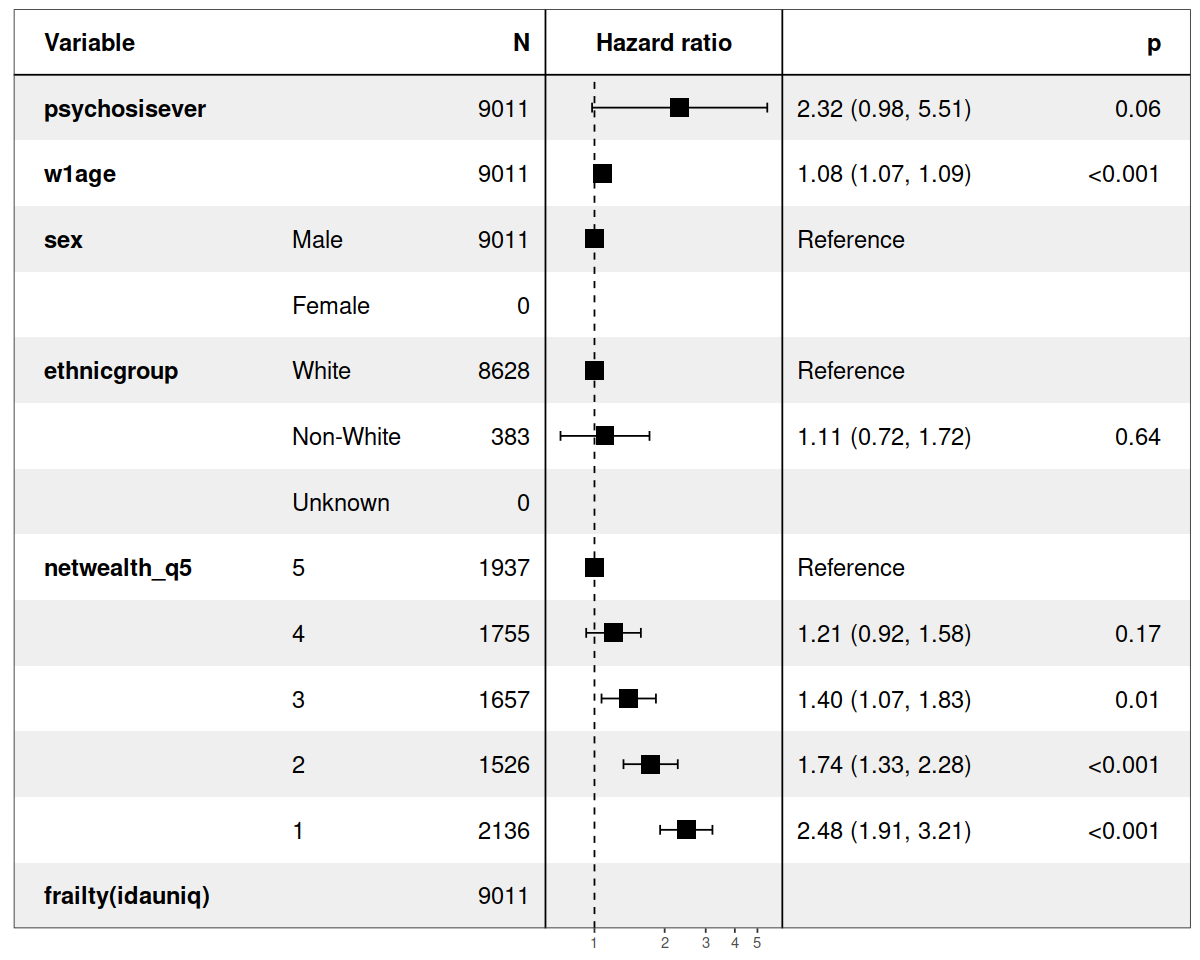

In [27]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadjimputedmale)

#### Males adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [28]:
strokeinpsychosis_coxadj2imputedmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_male
)

summary(strokeinpsychosis_coxadj2imputedmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 737 

                          coef     se(coef) se2      Chisq   DF   p      
psychosisever              0.76161 0.435983 0.387952    3.05    1 8.1e-02
w1age                      0.07371 0.003955 0.003611  347.28    1 1.7e-77
sexFemale                          0.000000 0.000000            1        
ethnicgroupNon-White      -0.01311 0.224599 0.201112    0.00    1 9.5e-01
ethnicgroupUnknown                 0.000000 0.000000            1        
netwealth_q54              0.14310 0.137262 0.124767    1.09    1 3.0e-01
netwealth_q53              0.26534 0.137460 0.124160    3.73    1 5.4e-02
netwealth_q52              0.41884 0.138554 0.124447    9.14    1 2.5e-03
netwealth_q51              0.69673 0.138076 0.124204 

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


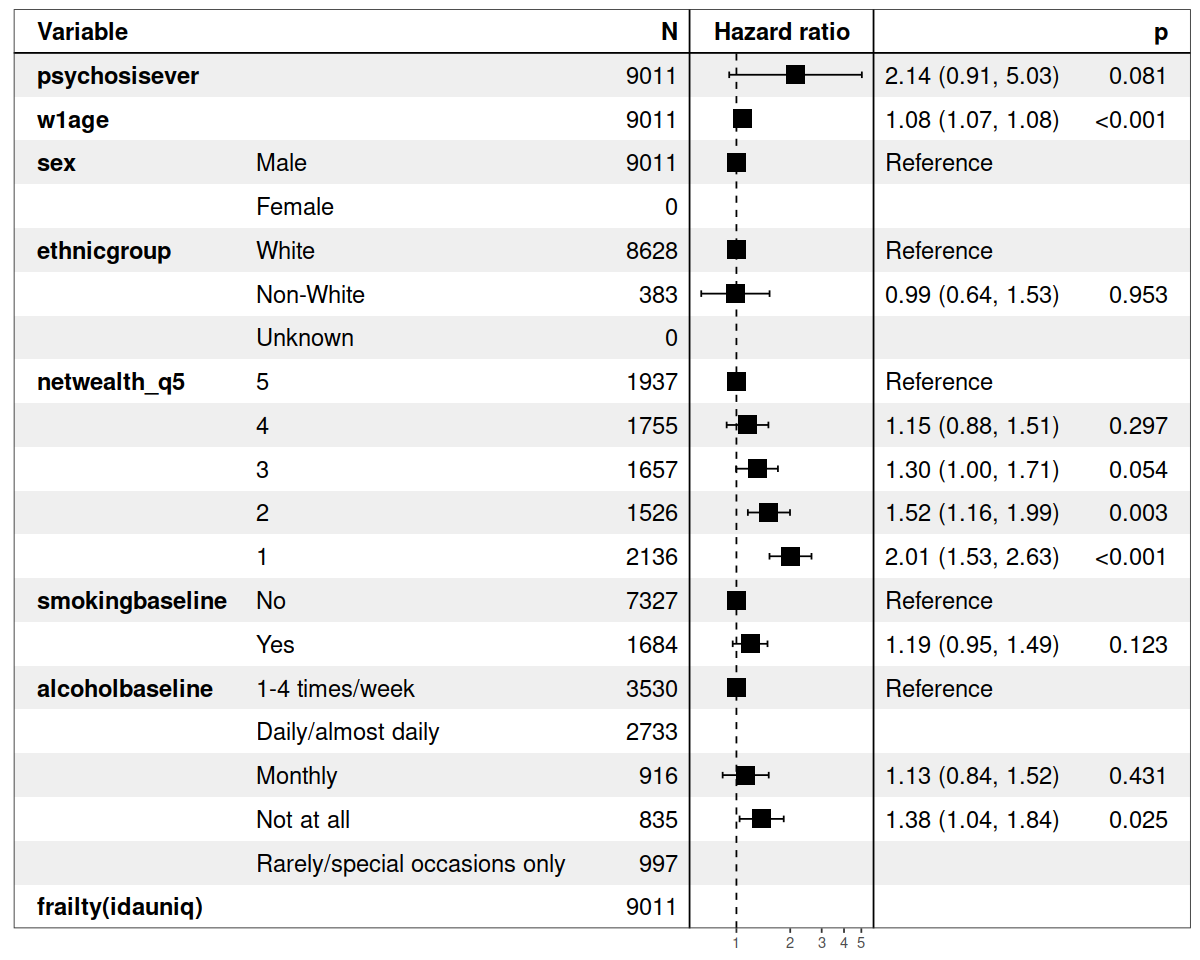

In [29]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputedmale)

### Age stratified analysis

#### Age <60

In [30]:
strokeinpsychosis_imp_ageless60 <- strokeinpsychosis_imp %>%
  filter(age_cat == "<60")

#### Age < 60, unadjusted with imputed data

In [31]:
strokeinpsychosis_coximputedageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = strokeinpsychosis_imp_ageless60
)

summary(strokeinpsychosis_coximputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = strokeinpsychosis_imp_ageless60)

  n= 11465, number of events= 111 

             coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 1.3022    3.6774   0.3488 3.734 0.000189 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.677     0.2719     1.856     7.285

Concordance= 0.54  (se = 0.017 )
Likelihood ratio test= 9.9  on 1 df,   p=0.002
Wald test            = 13.94  on 1 df,   p=2e-04
Score (logrank) test = 16.02  on 1 df,   p=6e-05


Resized limits to included dashed line in forest panel



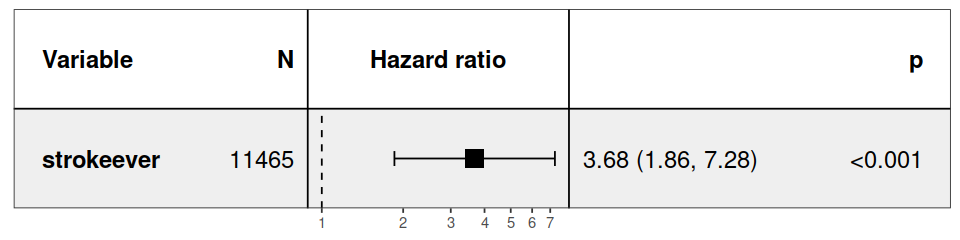

In [32]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(strokeinpsychosis_coximputedageless60)

#### Age <60 adjusted, model 1 (demographic covariates) with imputed data

In [33]:
strokeinpsychosis_coximputedageless60adj <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_ageless60
)

summary(strokeinpsychosis_coximputedageless60adj)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_ageless60)

  n= 11465, number of events= 369 

                     coef    se(coef) se2      Chisq  DF   p      
psychosisever         1.0453 0.39843  0.344868   6.88    1 8.7e-03
w1age                 0.0505 0.01024  0.009724  24.31    1 8.2e-07
sexFemale            -0.3868 0.11367  0.105293  11.58    1 6.7e-04
ethnicgroupNon-White  0.1226 0.24867  0.229048   0.24    1 6.2e-01
ethnicgroupUnknown           0.00000  0.000000           1        
netwealth_q54        -0.1393 0.20680  0.195320   0.45    1 5.0e-01
netwealth_q53         0.1797 0.20512  0.192673   0.77    1 3.8e-01
netwealth_q52         0.4727 0.20356  0.190015   5.39    1 2.0e-02
netwealth_q51         0.9358 0.17117  0.159110  29.89    1 4.6e-08
frailty(idauniq)                               979.83 1131 1.0e+00

                     exp(coef) exp(-co

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


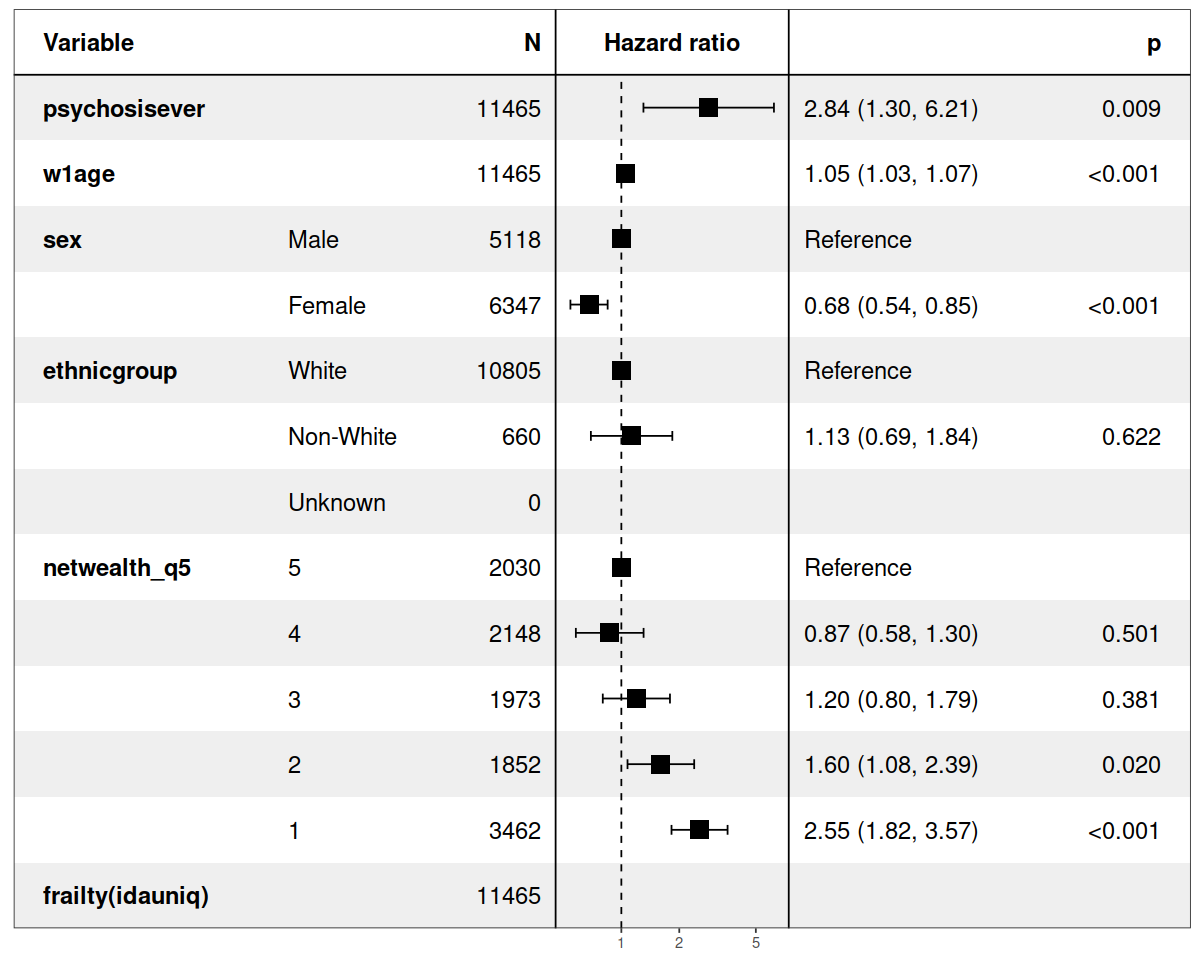

In [34]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coximputedageless60adj)

#### Age <60 adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [35]:
strokeinpsychosis_coxadj2imputedageless60 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_ageless60
)

summary(strokeinpsychosis_coxadj2imputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_ageless60)

  n= 11465, number of events= 369 

                          coef     se(coef) se2      Chisq   DF   p      
psychosisever              0.89194 0.4466   0.354163    3.99    1 4.6e-02
w1age                      0.04933 0.0109   0.009928   20.47    1 6.0e-06
sexFemale                 -0.54979 0.1267   0.110967   18.84    1 1.4e-05
ethnicgroupNon-White      -0.12366 0.2796   0.243064    0.20    1 6.6e-01
ethnicgroupUnknown                 0.0000   0.000000            1        
netwealth_q54             -0.25096 0.2216   0.198445    1.28    1 2.6e-01
netwealth_q53              0.04291 0.2220   0.197043    0.04    1 8.5e-01
netwealth_q52              0.19834 0.2229   0.196346    0.79    1 3.7e-01
netwealth_q51              0.47324 0.1996   0.1

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


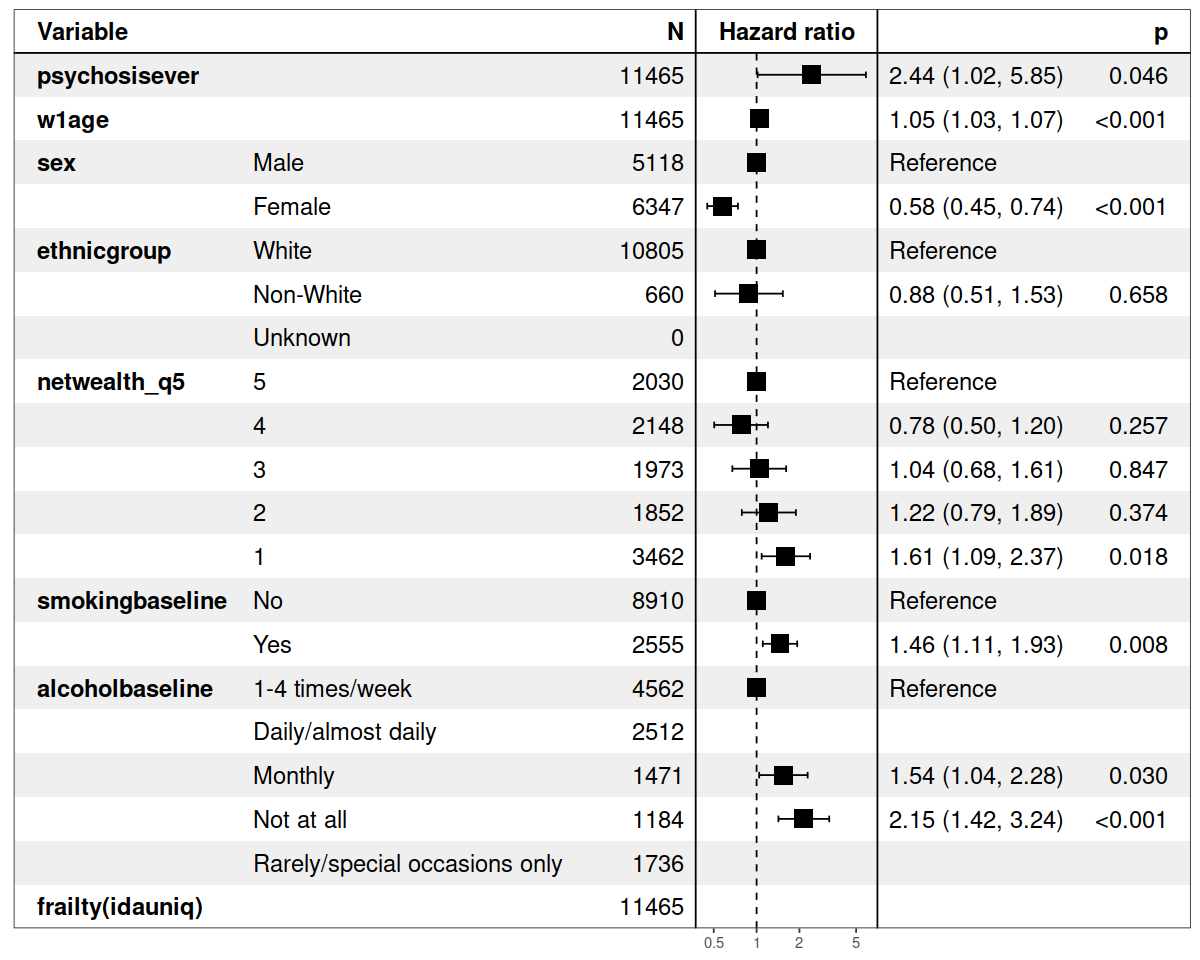

In [36]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputedageless60)

#### Age 60-69

In [37]:
strokeinpsychosis_imp_age60to69 <- strokeinpsychosis_imp %>%
  filter(age_cat == "60-69")

#### Age 60-69, unadjusted with imputed data

In [38]:
strokeinpsychosis_coximputedage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = strokeinpsychosis_imp_age60to69
)

summary(strokeinpsychosis_coximputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = strokeinpsychosis_imp_age60to69)

  n= 4280, number of events= 24 

             coef exp(coef) se(coef)     z Pr(>|z|)  
strokeever 1.3154    3.7262   0.5163 2.548   0.0108 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.726     0.2684     1.354     10.25

Concordance= 0.588  (se = 0.049 )
Likelihood ratio test= 5.07  on 1 df,   p=0.02
Wald test            = 6.49  on 1 df,   p=0.01
Score (logrank) test = 7.46  on 1 df,   p=0.006


Resized limits to included dashed line in forest panel



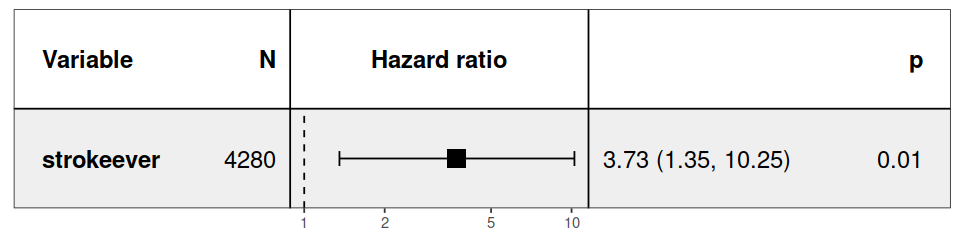

In [39]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(strokeinpsychosis_coximputedage60to69)

#### Age 60-69 model 1 (demographic covariates) with imputed data

In [40]:
strokeinpsychosis_coxadjimputedage60to69 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_age60to69
)

summary(strokeinpsychosis_coxadjimputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_age60to69)

  n= 4280, number of events= 420 

                     coef    se(coef) se2     Chisq   DF   p      
psychosisever         1.5226 0.63148  0.48202    5.81    1 1.6e-02
w1age                 0.1032 0.02109  0.01796   23.93    1 1.0e-06
sexFemale            -0.4235 0.11873  0.10058   12.72    1 3.6e-04
ethnicgroupNon-White -0.2343 0.34653  0.29117    0.46    1 5.0e-01
ethnicgroupUnknown           0.00000  0.00000            1        
netwealth_q54         0.2318 0.18921  0.16496    1.50    1 2.2e-01
netwealth_q53         0.5511 0.18499  0.15950    8.87    1 2.9e-03
netwealth_q52         0.9104 0.18867  0.16087   23.29    1 1.4e-06
netwealth_q51         1.0773 0.18579  0.15781   33.62    1 6.7e-09
frailty(idauniq)                              1015.27 1105 9.7e-01

                     exp(coef) exp(-coe

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


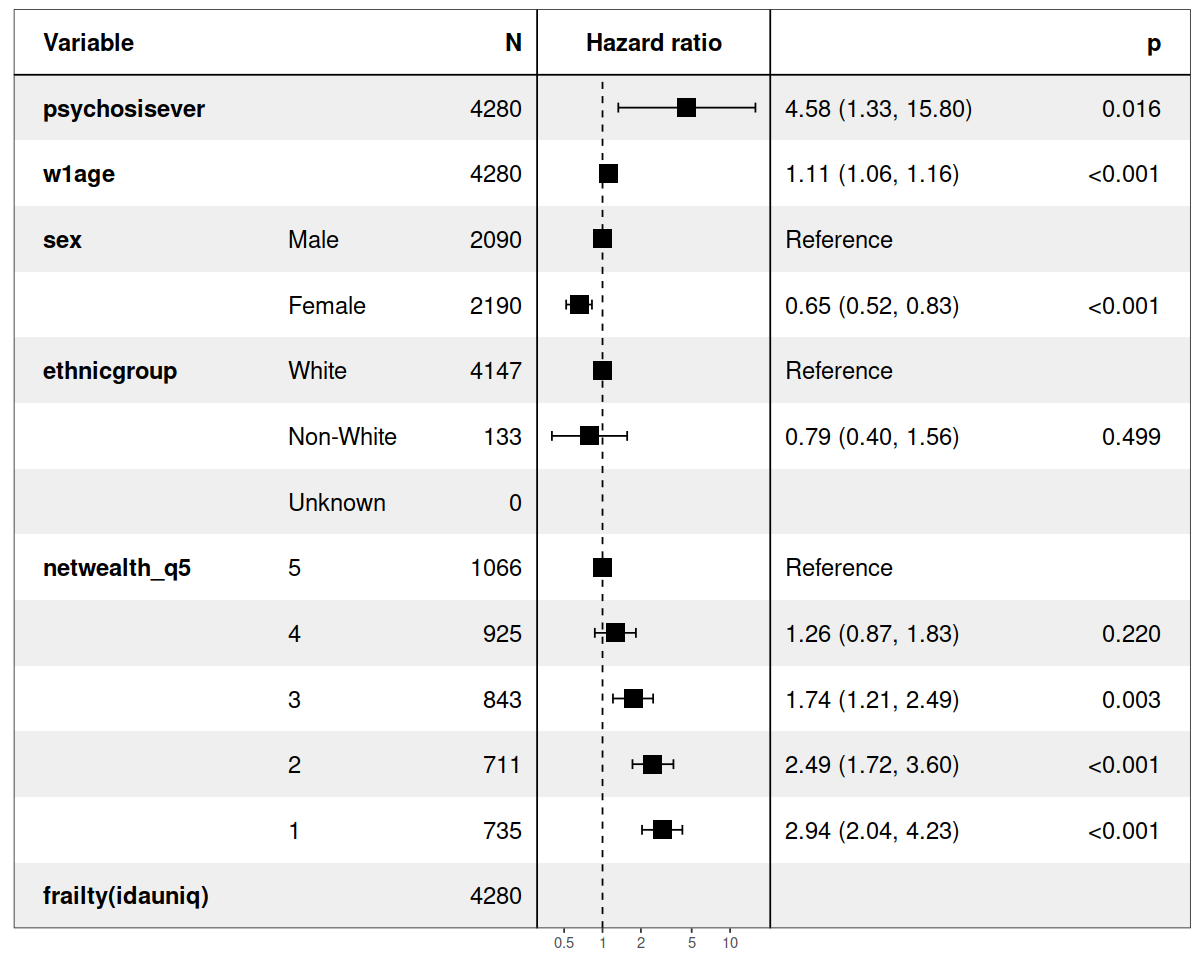

In [41]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadjimputedage60to69)

#### Age 60-69 model 2 (demographic and health behaviour covariates) with imputed data

In [42]:
strokeinpsychosis_coxadj2imputedage60to69 <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_age60to69
)

summary(strokeinpsychosis_coxadj2imputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_age60to69)

  n= 4280, number of events= 420 

                          coef     se(coef) se2     Chisq   DF   p      
psychosisever              1.52893 0.6741   0.49005    5.14    1 2.3e-02
w1age                      0.10604 0.0223   0.01832   22.62    1 2.0e-06
sexFemale                 -0.50453 0.1299   0.10622   15.09    1 1.0e-04
ethnicgroupNon-White      -0.33394 0.3677   0.29850    0.82    1 3.6e-01
ethnicgroupUnknown                 0.0000   0.00000            1        
netwealth_q54              0.21298 0.1993   0.16743    1.14    1 2.9e-01
netwealth_q53              0.51453 0.1973   0.16370    6.80    1 9.1e-03
netwealth_q52              0.84391 0.2046   0.16801   17.02    1 3.7e-05
netwealth_q51              0.95255 0.2076   0.16925   21.

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


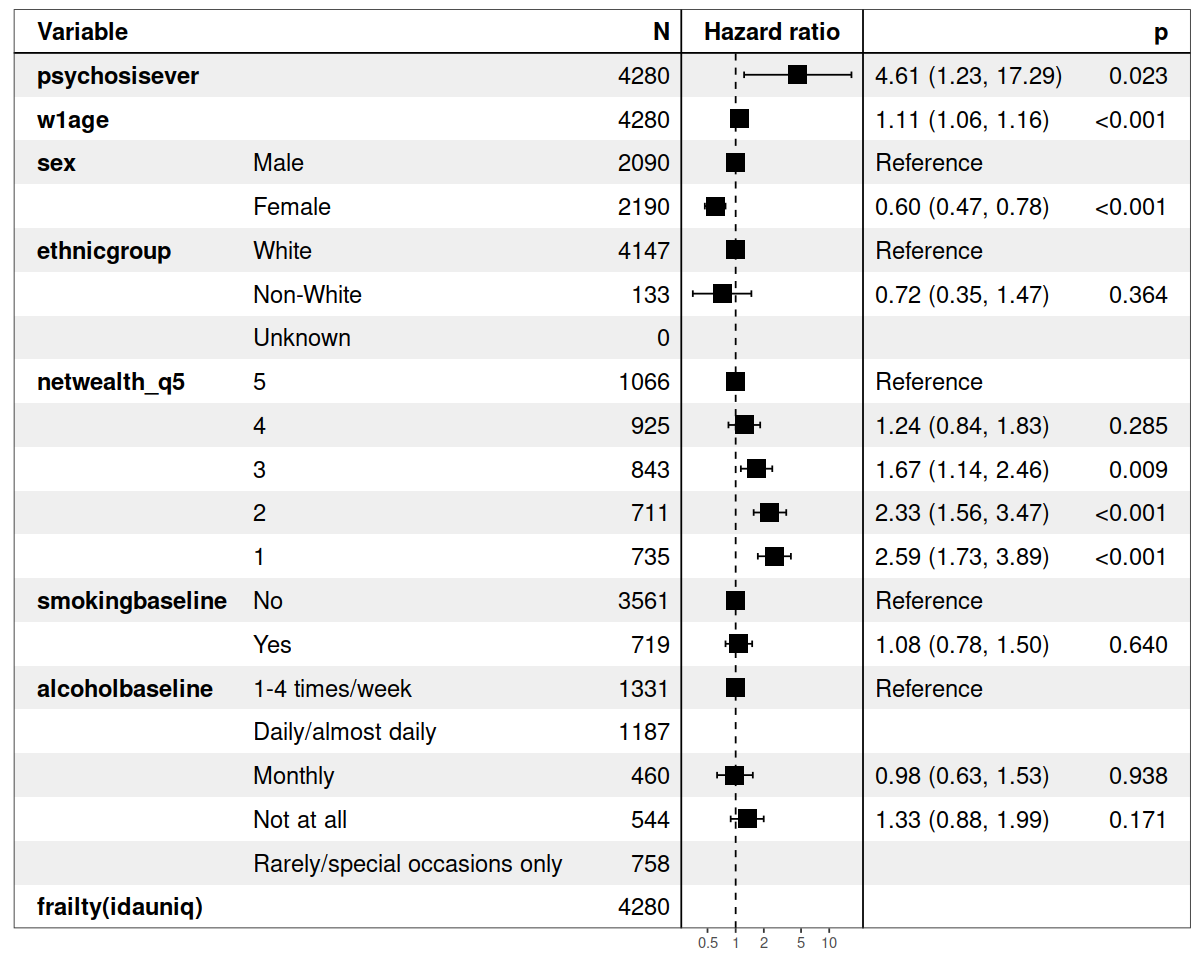

In [43]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputedage60to69)

#### Age 70+

In [44]:
strokeinpsychosis_imp_age70plus <- strokeinpsychosis_imp %>%
  filter(age_cat == "70+")

#### Age 70+, unadjusted with imputed data

In [45]:
strokeinpsychosis_coximputedage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = strokeinpsychosis_imp_age70plus
)

summary(strokeinpsychosis_coximputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = strokeinpsychosis_imp_age70plus)

  n= 4061, number of events= 27 

            coef exp(coef) se(coef)     z Pr(>|z|)   
strokeever 1.300     3.670    0.403 3.226  0.00126 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.669     0.2725     1.666     8.084

Concordance= 0.625  (se = 0.05 )
Likelihood ratio test= 8.91  on 1 df,   p=0.003
Wald test            = 10.41  on 1 df,   p=0.001
Score (logrank) test = 11.91  on 1 df,   p=6e-04


Resized limits to included dashed line in forest panel



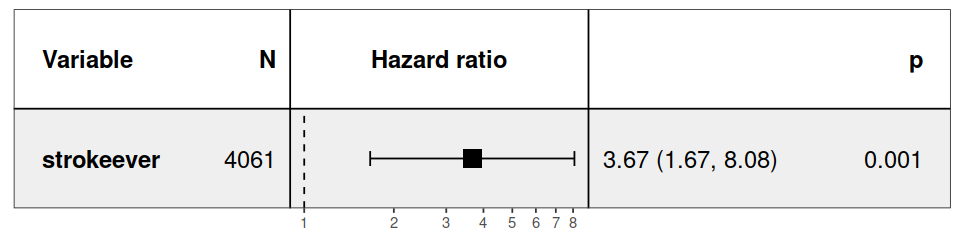

In [46]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(strokeinpsychosis_coximputedage70plus)

#### Age 70+ model 1 (demographic covariates) with imputed data

In [47]:
strokeinpsychosis_coxadjimputedage70plus <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq),
  data = strokeinpsychosis_imp_age70plus
)

summary(strokeinpsychosis_coxadjimputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = strokeinpsychosis_imp_age70plus)

  n= 4061, number of events= 673 

                     coef     se(coef) se2      Chisq DF   p      
psychosisever         1.30915 0.319818 0.319431 16.76 1.00 4.3e-05
w1age                 0.04802 0.007346 0.007343 42.73 1.00 6.3e-11
sexFemale            -0.22830 0.078578 0.078537  8.44 1.00 3.7e-03
ethnicgroupNon-White  0.21592 0.265109 0.264935  0.66 1.00 4.2e-01
ethnicgroupUnknown            0.000000 0.000000       1.00        
netwealth_q54         0.03996 0.139413 0.139351  0.08 1.00 7.7e-01
netwealth_q53         0.27872 0.128987 0.128923  4.67 1.00 3.1e-02
netwealth_q52         0.32163 0.125031 0.124970  6.62 1.00 1.0e-02
netwealth_q51         0.39307 0.138666 0.138597  8.04 1.00 4.6e-03
frailty(idauniq)                                 3.37 3.35 4.0e-01

                     exp(coef) exp(-coe

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


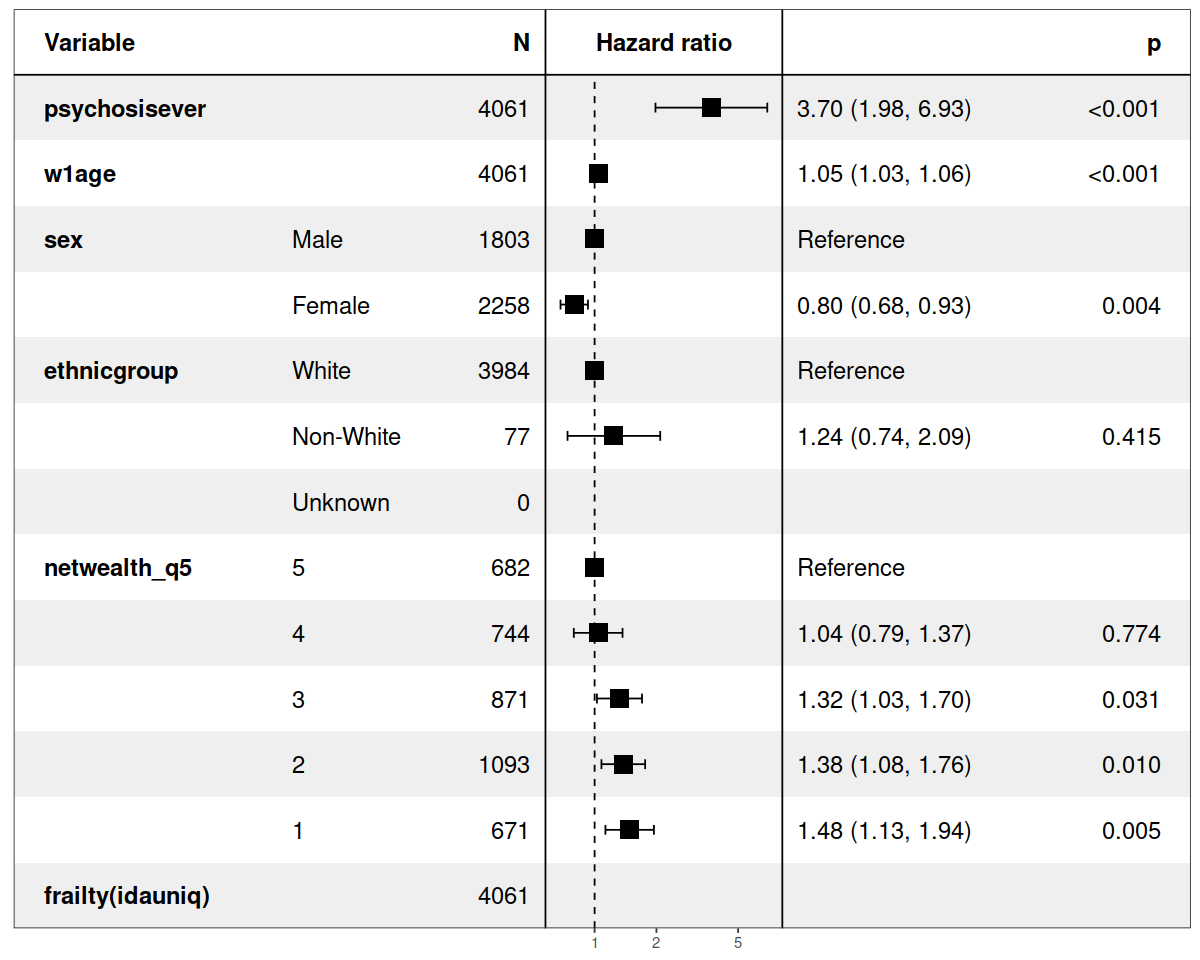

In [48]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadjimputedage70plus)

#### Age 70+ adjusted model 2 (with demographic and health behaviour covariates)

In [49]:
strokeinpsychosis_coxadj2imputedage70plus <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_age70plus
)

summary(strokeinpsychosis_coxadj2imputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_age70plus)

  n= 4061, number of events= 673 

                          coef     se(coef) se2      Chisq  DF    p      
psychosisever              1.39935 0.360165 0.323678  15.10   1.0 1.0e-04
w1age                      0.04852 0.007898 0.007523  37.74   1.0 8.1e-10
sexFemale                 -0.28774 0.085751 0.081575  11.26   1.0 7.9e-04
ethnicgroupNon-White       0.12243 0.283916 0.267554   0.19   1.0 6.7e-01
ethnicgroupUnknown                 0.000000 0.000000          1.0        
netwealth_q54              0.02780 0.145858 0.139611   0.04   1.0 8.5e-01
netwealth_q53              0.26667 0.136674 0.130305   3.81   1.0 5.1e-02
netwealth_q52              0.28501 0.133500 0.127395   4.56   1.0 3.3e-02
netwealth_q51              0.31749 0.149945 0.14

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


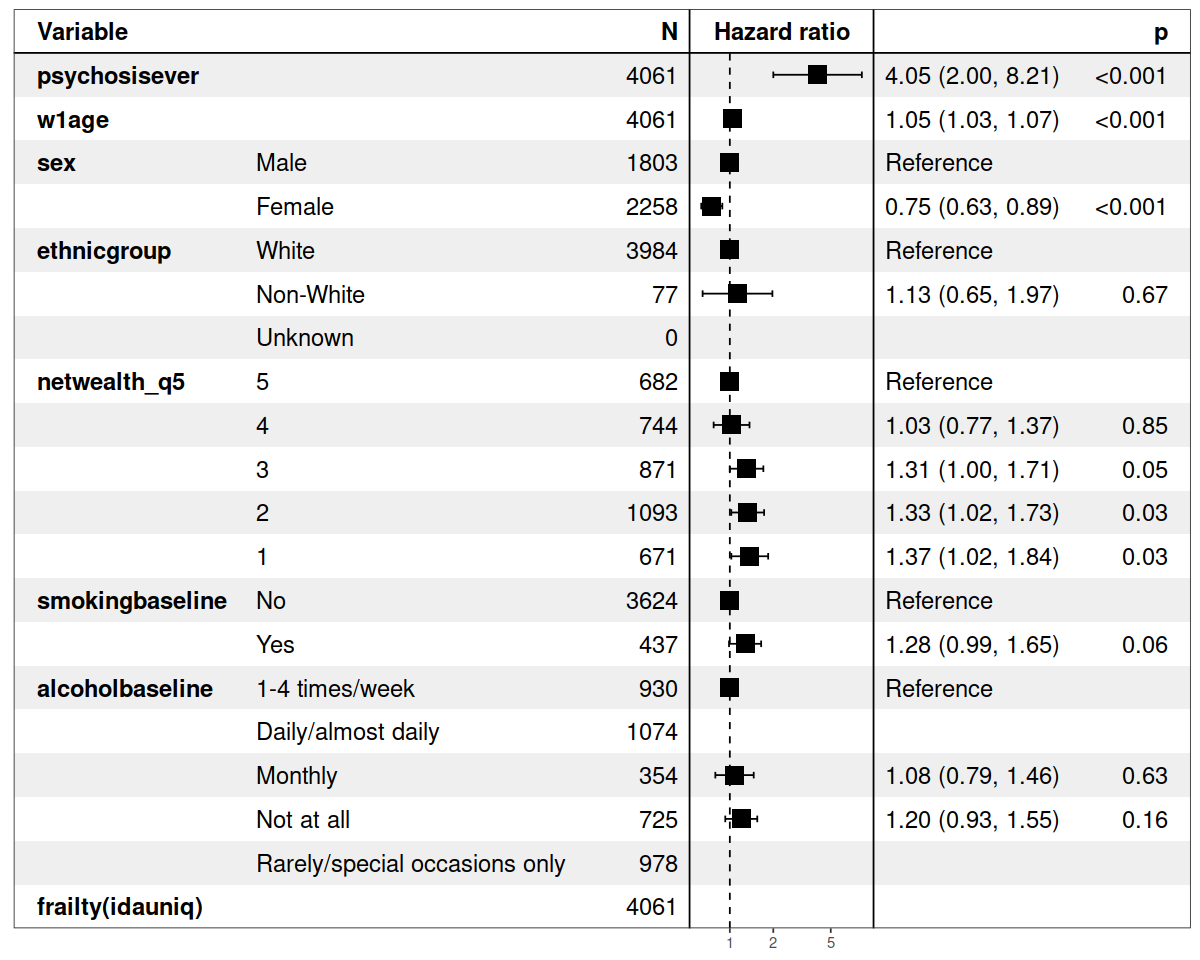

In [50]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputedage70plus)

## Psychosis in the stroke population survival analyses

### Cox proportional hazards regression models

#### Adjusted, model 1 (demographic covariates) with imputed data

In [51]:
# Fit model
psychosisinstroke_coxadjimputed <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp
)

summary(psychosisinstroke_coxadjimputed)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp)

  n= 19808, number of events= 162 

                     coef    se(coef) se2      Chisq   DF   p      
strokeever            1.5079 0.343022 0.261606   19.32    1 1.1e-05
w1age                -0.0223 0.008844 0.007334    6.36    1 1.2e-02
sexFemale             0.1710 0.208183 0.168051    0.67    1 4.1e-01
ethnicgroupNon-White -0.3655 0.539537 0.440536    0.46    1 5.0e-01
ethnicgroupUnknown           0.000000 0.000000            1        
netwealth_q54         0.5005 0.374801 0.321321    1.78    1 1.8e-01
netwealth_q53         0.5306 0.378672 0.324486    1.96    1 1.6e-01
netwealth_q52         0.7431 0.372877 0.317868    3.97    1 4.6e-02
netwealth_q51         1.7664 0.333709 0.283635   28.02    1 1.2e-07
frailty(idauniq)                               2369.06 6638 1.0e+00

                     exp(coef) exp(-c

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


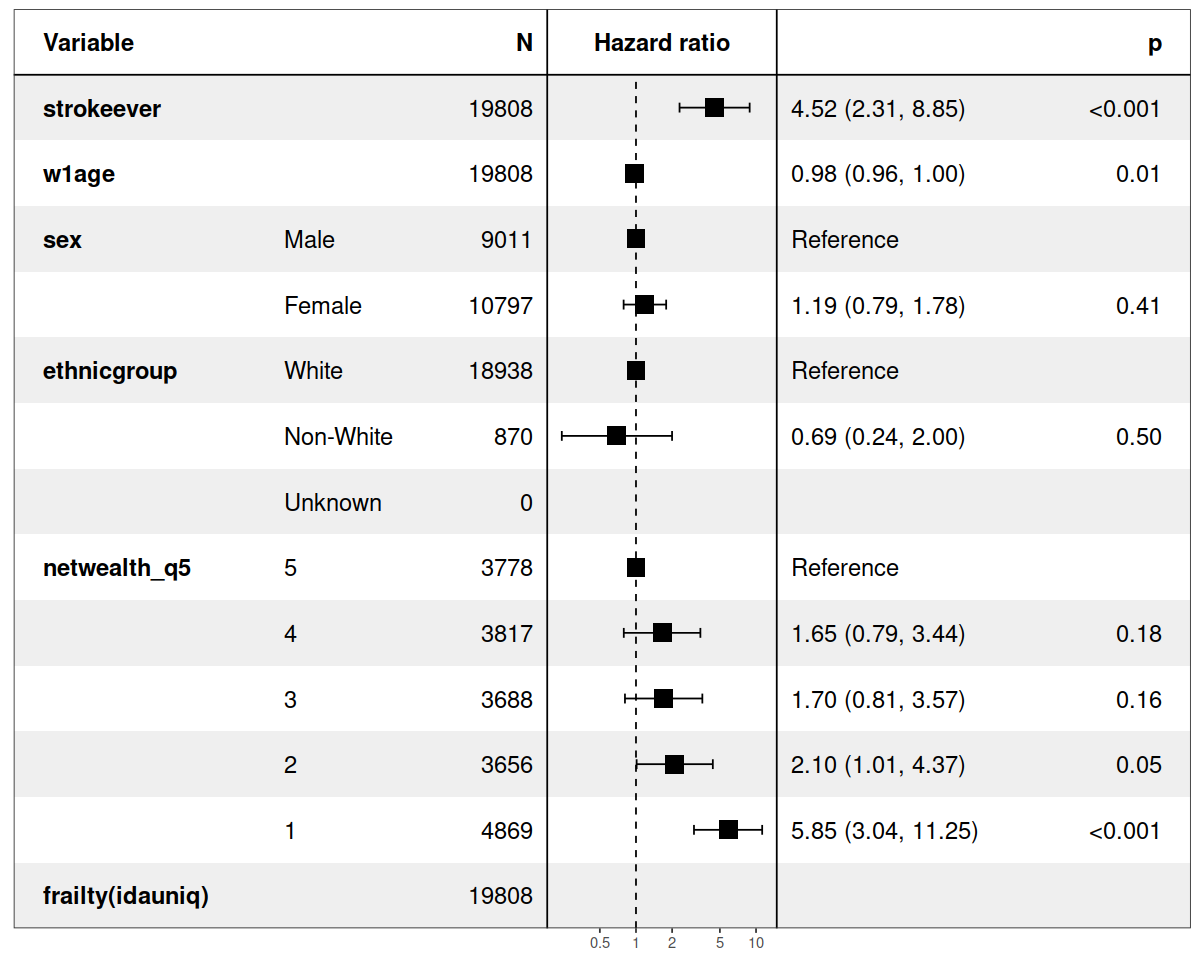

In [52]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputed)

#### Adjusted, model 2 (demographic and health behaviour covariates) with imputed data

In [53]:
# Fit model
psychosisinstroke_coxadj2imputed <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp
)

summary(psychosisinstroke_coxadj2imputed)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp)

  n= 19808, number of events= 162 

                          coef     se(coef) se2     Chisq   DF   p      
strokeever                 1.54233 0.359294 0.27045   18.43    1 1.8e-05
w1age                     -0.03456 0.009636 0.00785   12.86    1 3.4e-04
sexFemale                 -0.06111 0.224577 0.17861    0.07    1 7.9e-01
ethnicgroupNon-White      -0.78329 0.570200 0.45910    1.89    1 1.7e-01
ethnicgroupUnknown                 0.000000 0.00000            1        
netwealth_q54              0.37638 0.392975 0.32945    0.92    1 3.4e-01
netwealth_q53              0.34214 0.399700 0.33417    0.73    1 3.9e-01
netwealth_q52              0.33398 0.396768 0.32969    0.71    1 4.0e-01
netwealth_q51              1.01508 0.374469 0.30538    7.35    1 6

Plot as forest plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


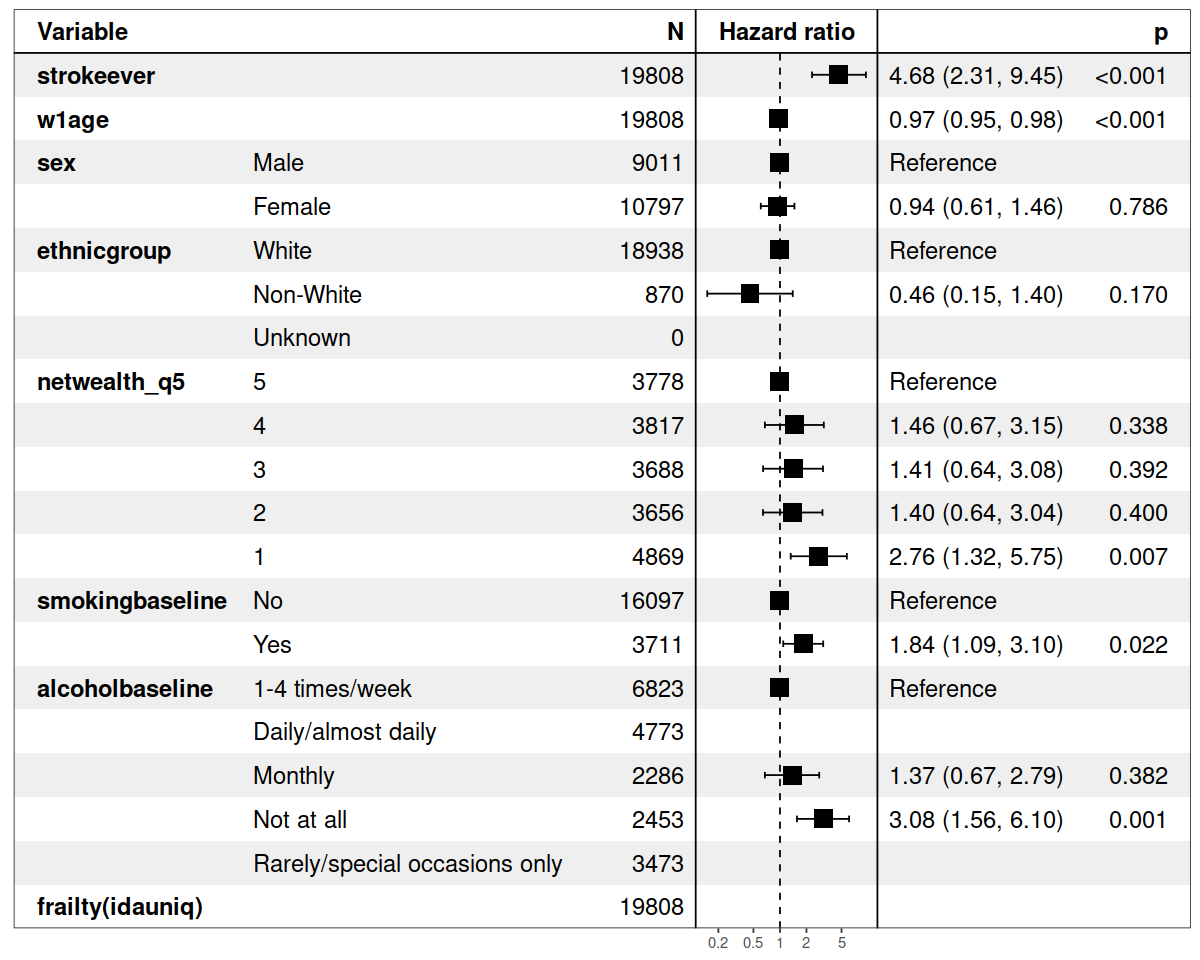

In [54]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2imputed)

### Sex stratified analysis

#### Females only

In [55]:
psychosisinstroke_imp_female <- psychosisinstroke_imp %>%
  filter(sex == "Female")

#### Females unadjusted with imputed data

In [56]:
# Fit model
psychosisinstroke_coximputedfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_imp_female
)

summary(psychosisinstroke_coximputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_imp_female)

  n= 10797, number of events= 96 

             coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 1.3301    3.7814   0.2691 4.943 7.68e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.781     0.2645     2.232     6.407

Concordance= 0.573  (se = 0.022 )
Likelihood ratio test= 18.3  on 1 df,   p=2e-05
Wald test            = 24.44  on 1 df,   p=8e-07
Score (logrank) test = 28.23  on 1 df,   p=1e-07


Resized limits to included dashed line in forest panel



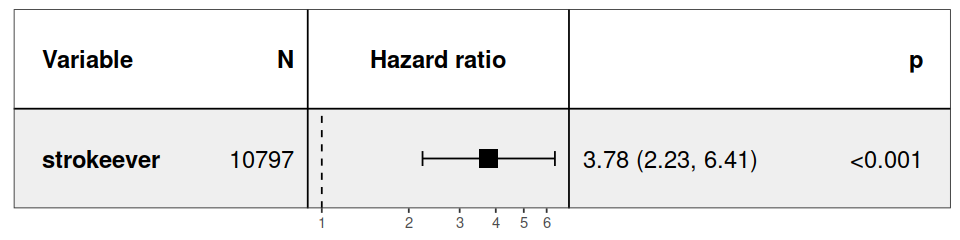

In [57]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedfemale)

#### Females adjusted, model 1 (demographic covariates) with imputed data

In [58]:
# Fit model
psychosisinstroke_coxadjimputedfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_female
)

summary(psychosisinstroke_coxadjimputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_female)

  n= 10797, number of events= 96 

                     coef      se(coef) se2      Chisq   DF   p      
strokeever            1.724665 0.37579  0.306080   21.06    1 4.4e-06
w1age                -0.007933 0.01005  0.008885    0.62    1 4.3e-01
sexFemale                      0.00000  0.000000            1        
ethnicgroupNon-White -0.397577 0.67101  0.600267    0.35    1 5.5e-01
ethnicgroupUnknown             0.00000  0.000000            1        
netwealth_q54         0.434275 0.41192  0.363823    1.11    1 2.9e-01
netwealth_q53        -0.084434 0.44964  0.404151    0.04    1 8.5e-01
netwealth_q52         0.385598 0.41698  0.369559    0.86    1 3.6e-01
netwealth_q51         0.906212 0.38169  0.334834    5.64    1 1.8e-02
frailty(idauniq)                                 1050.65 2292 1.0e+00

         

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


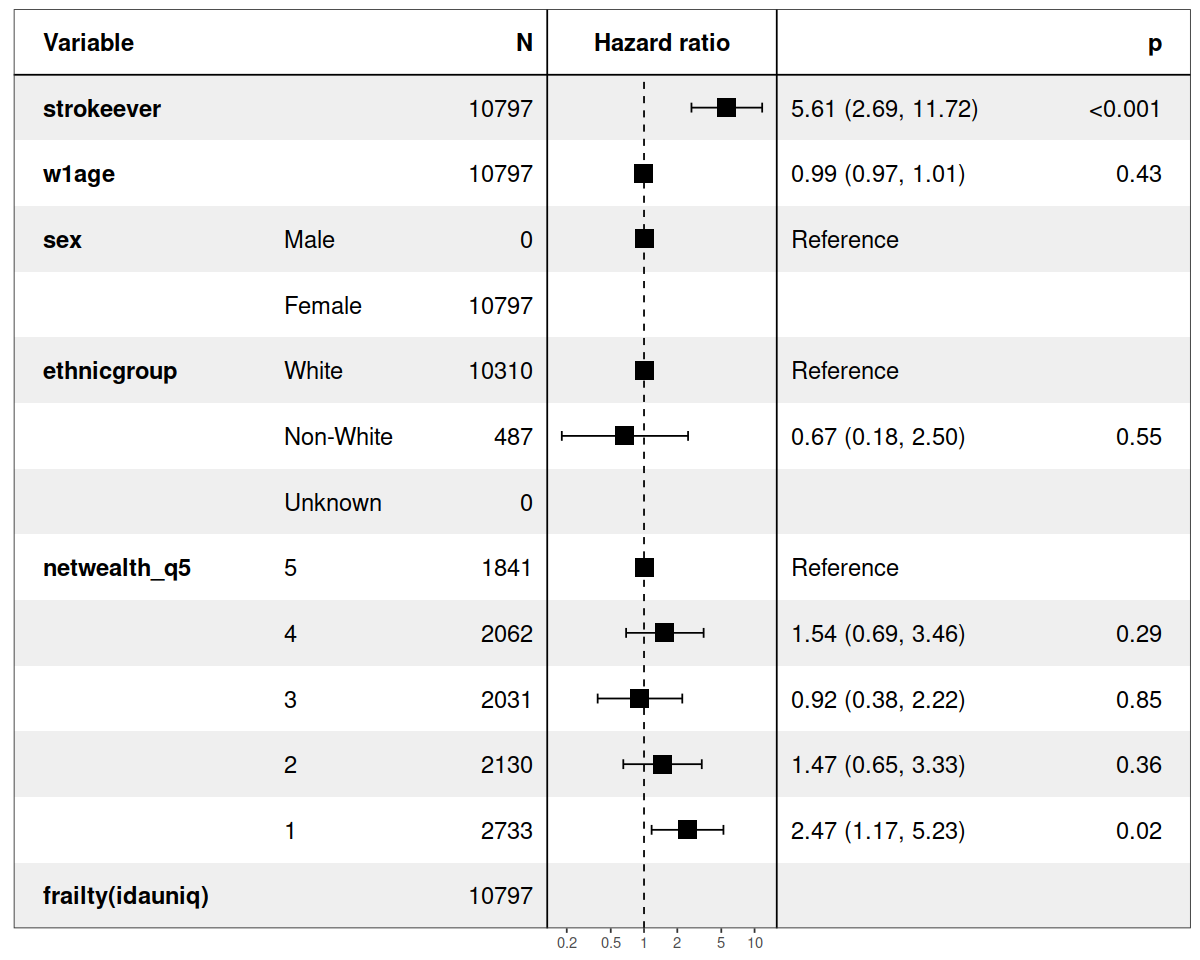

In [59]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputedfemale)

#### Females adjusted model 2 (with demographic and health behaviour covariates)

In [60]:
psychosisinstroke_coxadj2imputedfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_female
)

summary(psychosisinstroke_coxadj2imputedfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_female)

  n= 10797, number of events= 96 

                          coef     se(coef) se2      Chisq   DF   p      
strokeever                 1.78491 0.4177   0.323950   18.26    1 1.9e-05
w1age                     -0.02328 0.0114   0.009501    4.17    1 4.1e-02
sexFemale                          0.0000   0.000000            1        
ethnicgroupNon-White      -0.84930 0.7374   0.628129    1.33    1 2.5e-01
ethnicgroupUnknown                 0.0000   0.000000            1        
netwealth_q54              0.30813 0.4537   0.376472    0.46    1 5.0e-01
netwealth_q53             -0.37952 0.4963   0.419193    0.58    1 4.4e-01
netwealth_q52             -0.05221 0.4663   0.388203    0.01    1 9.1e-01
netwealth_q51              0.15122 0.4565   0.37301

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


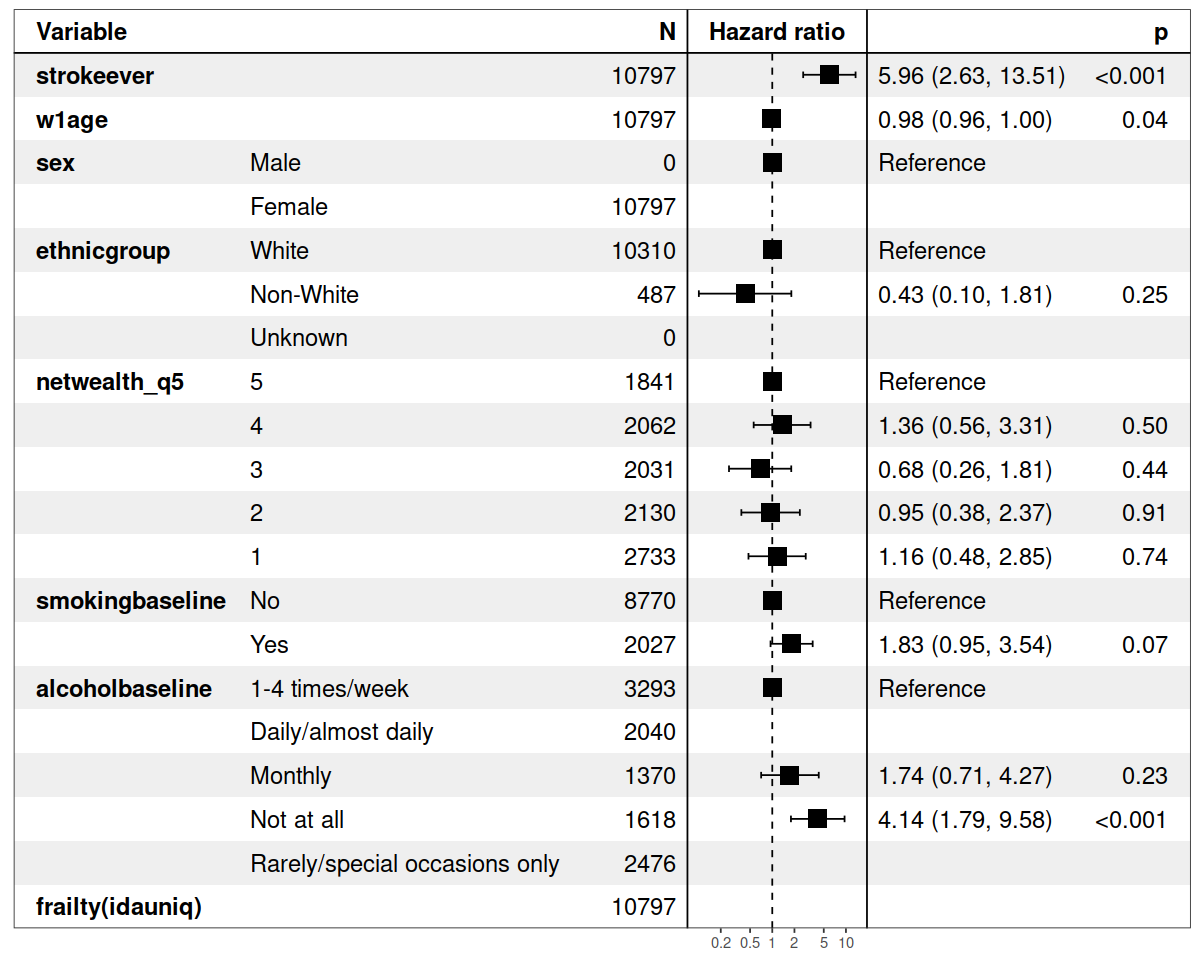

In [61]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2imputedfemale)

#### Males only

In [62]:
psychosisinstroke_imp_male <- psychosisinstroke_imp %>%
  filter(sex == "Male")

#### Males unadjusted with imputed data

In [63]:
# Fit model
psychosisinstroke_coximputedmale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_imp_male
)

summary(psychosisinstroke_coximputedmale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_imp_male)

  n= 9011, number of events= 66 

             coef exp(coef) se(coef)     z Pr(>|z|)
strokeever 0.4231    1.5267   0.4006 1.056    0.291

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     1.527      0.655    0.6963     3.348

Concordance= 0.521  (se = 0.021 )
Likelihood ratio test= 1  on 1 df,   p=0.3
Wald test            = 1.12  on 1 df,   p=0.3
Score (logrank) test = 1.13  on 1 df,   p=0.3


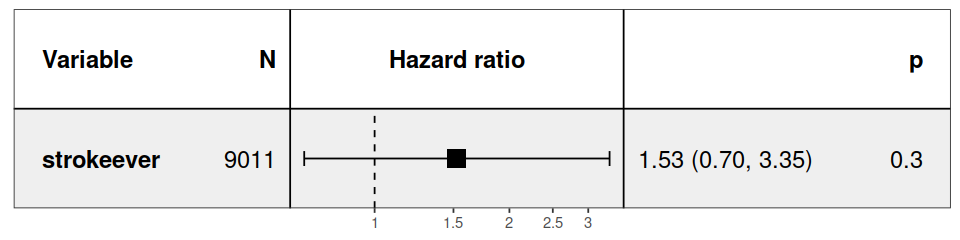

In [64]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedmale)

#### Males adjusted, model 1 (demographic covariates) with imputed data

In [65]:
psychosisinstroke_coxadjimputedmale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_male
)

summary(psychosisinstroke_coxadjimputedmale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_male)

  n= 9011, number of events= 66 

                     coef    se(coef) se2     Chisq  DF   p      
strokeever            0.8856 0.57189  0.45257   2.40    1 1.2e-01
w1age                -0.0422 0.01494  0.01276   7.98    1 4.7e-03
sexFemale                    0.00000  0.00000           1        
ethnicgroupNon-White -0.3154 0.78060  0.62966   0.16    1 6.9e-01
ethnicgroupUnknown           0.00000  0.00000           1        
netwealth_q54         0.3493 0.72258  0.67245   0.23    1 6.3e-01
netwealth_q53         1.3923 0.64485  0.58798   4.66    1 3.1e-02
netwealth_q52         1.1586 0.67642  0.61748   2.93    1 8.7e-02
netwealth_q51         2.6760 0.59126  0.54453  20.48    1 6.0e-06
frailty(idauniq)                              911.78 2411 1.0e+00

                     exp(coef) exp(-coef) lower .95 uppe

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


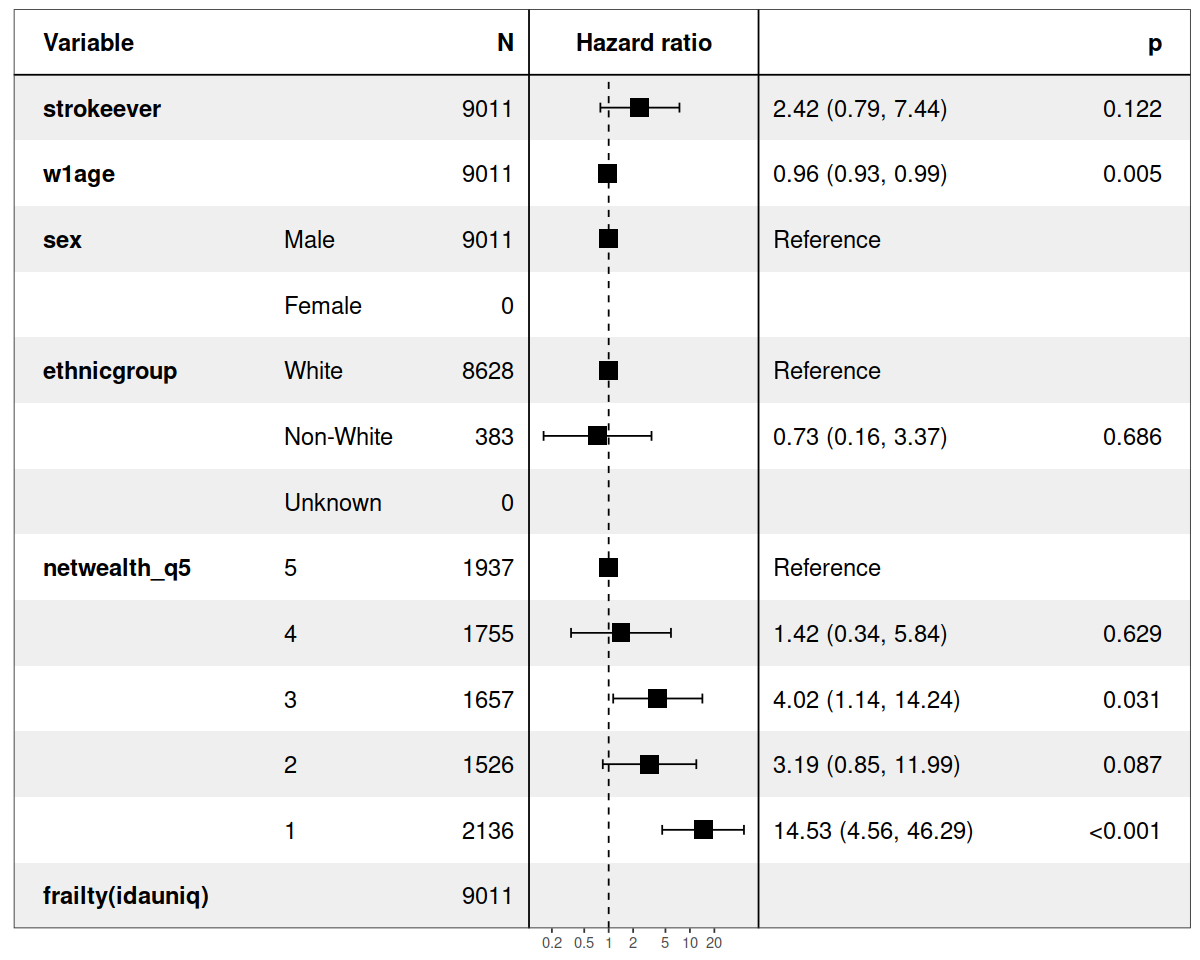

In [66]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputedmale)

#### Males adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [67]:
strokeinpsychosis_coxadj2imputedmale <-  survival::coxph(
  Surv(fuptime, strokeever) ~ psychosisever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = strokeinpsychosis_imp_male
)

summary(strokeinpsychosis_coxadj2imputedmale)

Call:
survival::coxph(formula = Surv(fuptime, strokeever) ~ psychosisever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = strokeinpsychosis_imp_male)

  n= 9011, number of events= 737 

                          coef     se(coef) se2      Chisq   DF   p      
psychosisever              0.76161 0.435983 0.387952    3.05    1 8.1e-02
w1age                      0.07371 0.003955 0.003611  347.28    1 1.7e-77
sexFemale                          0.000000 0.000000            1        
ethnicgroupNon-White      -0.01311 0.224599 0.201112    0.00    1 9.5e-01
ethnicgroupUnknown                 0.000000 0.000000            1        
netwealth_q54              0.14310 0.137262 0.124767    1.09    1 3.0e-01
netwealth_q53              0.26534 0.137460 0.124160    3.73    1 5.4e-02
netwealth_q52              0.41884 0.138554 0.124447    9.14    1 2.5e-03
netwealth_q51              0.69673 0.138076 0.124204 

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


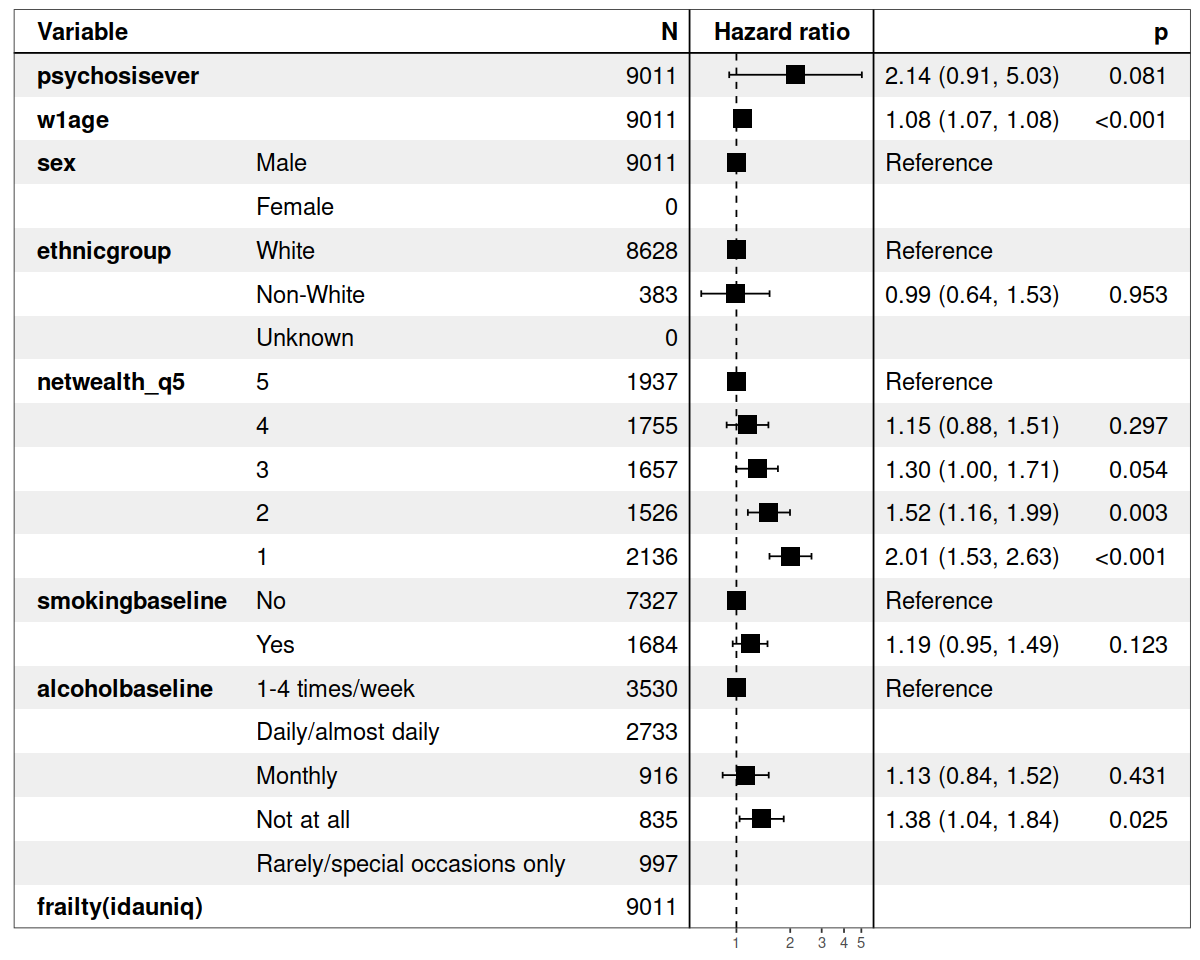

In [68]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(strokeinpsychosis_coxadj2imputedmale)

### Age stratified analysis

#### Age <60

In [69]:
psychosisinstroke_imp_ageless60 <- psychosisinstroke_imp %>%
  filter(age_cat == "<60")

#### Age < 60 unadjusted with imputed data

In [70]:
# Fit model
psychosisinstroke_coximputedageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_imp_ageless60
)

summary(psychosisinstroke_coximputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_imp_ageless60)

  n= 11465, number of events= 111 

             coef exp(coef) se(coef)     z Pr(>|z|)   
strokeever 1.1046    3.0181   0.3483 3.172  0.00152 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.018     0.3313     1.525     5.973

Concordance= 0.532  (se = 0.015 )
Likelihood ratio test= 7.5  on 1 df,   p=0.006
Wald test            = 10.06  on 1 df,   p=0.002
Score (logrank) test = 11.12  on 1 df,   p=9e-04


Resized limits to included dashed line in forest panel



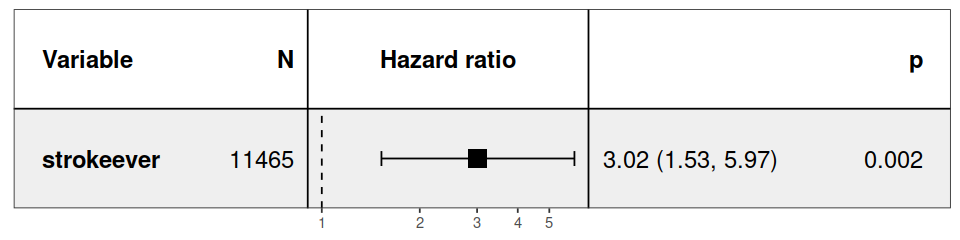

In [71]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedageless60)

#### Age <60 adjusted, model 1 (demographic covariates) with imputed data

In [72]:
psychosisinstroke_coxadjimputedageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_ageless60
)

summary(psychosisinstroke_coxadjimputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_ageless60)

  n= 11465, number of events= 111 

                     coef      se(coef) se2     Chisq   DF   p      
strokeever            1.240803 0.50624  0.37989    6.01    1 1.4e-02
w1age                 0.004737 0.01779  0.01521    0.07    1 7.9e-01
sexFemale            -0.076663 0.23622  0.19699    0.11    1 7.5e-01
ethnicgroupNon-White -0.172429 0.52079  0.43566    0.11    1 7.4e-01
ethnicgroupUnknown             0.00000  0.00000            1        
netwealth_q54         0.754182 0.48403  0.44008    2.43    1 1.2e-01
netwealth_q53         0.650138 0.50393  0.45917    1.66    1 2.0e-01
netwealth_q52         1.051510 0.48475  0.43726    4.71    1 3.0e-02
netwealth_q51         2.025791 0.42560  0.38681   22.66    1 1.9e-06
frailty(idauniq)                                1340.66 3147 1.0e+00

                

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


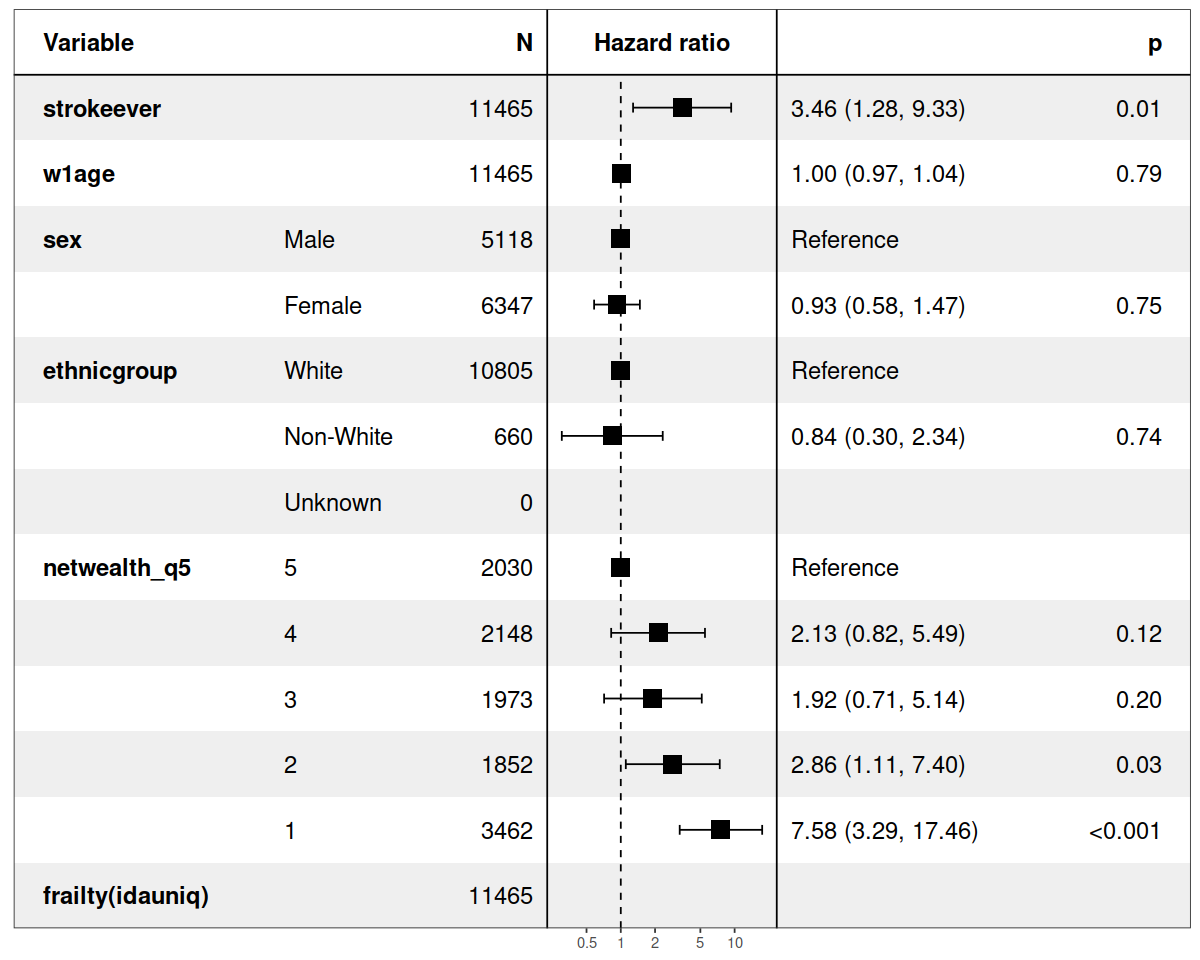

In [73]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputedageless60)

#### Age <60 adjusted model 2 (demographic and health behaviour covariates) with imputed data

In [74]:
psychosisinstroke_coxadj2imputedageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_ageless60
)

summary(psychosisinstroke_coxadj2imputedageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_ageless60)

  n= 11465, number of events= 111 

                          coef      se(coef) se2     Chisq   DF   p      
strokeever                 1.222438 0.56028  0.40257    4.76    1 2.9e-02
w1age                      0.001278 0.01961  0.01614    0.00    1 9.5e-01
sexFemale                 -0.213872 0.26531  0.21235    0.65    1 4.2e-01
ethnicgroupNon-White      -0.623884 0.59076  0.47219    1.12    1 2.9e-01
ethnicgroupUnknown                  0.00000  0.00000            1        
netwealth_q54              0.705008 0.51933  0.45082    1.84    1 1.7e-01
netwealth_q53              0.569439 0.54321  0.47100    1.10    1 2.9e-01
netwealth_q52              0.717553 0.52415  0.44986    1.87    1 1.7e-01
netwealth_q51              1.327676 0.48142  0.

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


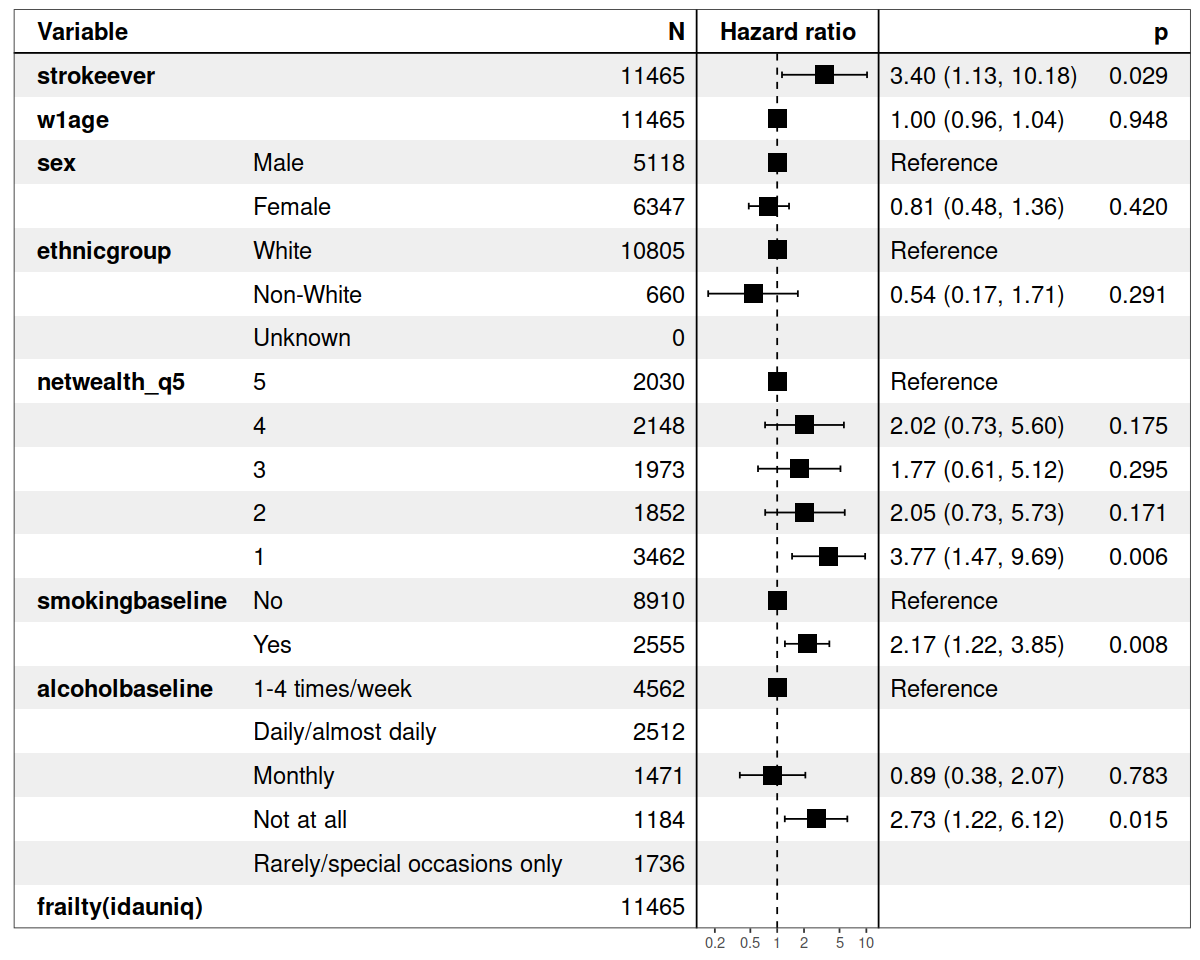

In [75]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2imputedageless60)

#### Age 60-69

In [76]:
psychosisinstroke_imp_age60to69 <- psychosisinstroke_imp %>%
  filter(age_cat == "60-69")

#### Age 60-69 unadjusted with imputed data

In [77]:
# Fit model
psychosisinstroke_coximputedage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_imp_age60to69
)

summary(psychosisinstroke_coximputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_imp_age60to69)

  n= 4280, number of events= 24 

             coef exp(coef) se(coef)     z Pr(>|z|)  
strokeever 1.1728    3.2311   0.5064 2.316   0.0206 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.231     0.3095     1.198     8.717

Concordance= 0.577  (se = 0.046 )
Likelihood ratio test= 4.24  on 1 df,   p=0.04
Wald test            = 5.36  on 1 df,   p=0.02
Score (logrank) test = 6  on 1 df,   p=0.01


Resized limits to included dashed line in forest panel



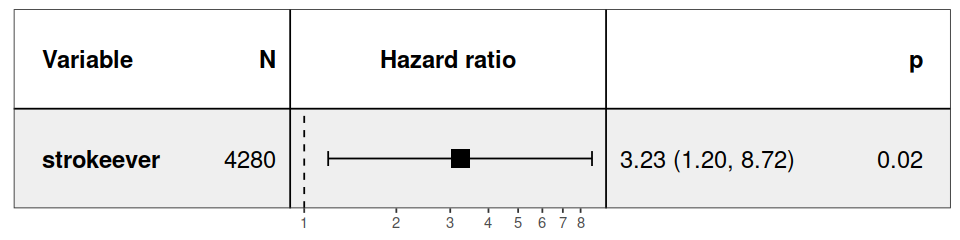

In [78]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedage60to69)

#### Age 60-69 model 1 (demographic covariates) with imputed data

In [79]:
psychosisinstroke_coxadjimputedage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_age60to69
)

summary(psychosisinstroke_coxadjimputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_age60to69)

  n= 4280, number of events= 24 

                     coef      se(coef)  se2       Chisq DF p    
strokeever             1.06911 5.130e-01 5.130e-01 4.34  1  0.037
w1age                 -0.01847 7.252e-02 7.252e-02 0.06  1  0.800
sexFemale              0.75845 4.507e-01 4.507e-01 2.83  1  0.092
ethnicgroupNon-White -18.35010 1.059e+04 1.059e+04 0.00  1  1.000
ethnicgroupUnknown             0.000e+00 0.000e+00       1       
netwealth_q54         -0.15460 7.641e-01 7.641e-01 0.04  1  0.840
netwealth_q53          0.64402 6.488e-01 6.488e-01 0.99  1  0.320
netwealth_q52          0.14346 7.688e-01 7.688e-01 0.03  1  0.850
netwealth_q51          1.16520 6.193e-01 6.193e-01 3.54  1  0.060
frailty(idauniq)                                   0.00  0  0.830

                     exp(coef) exp(-coef) lower .95

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


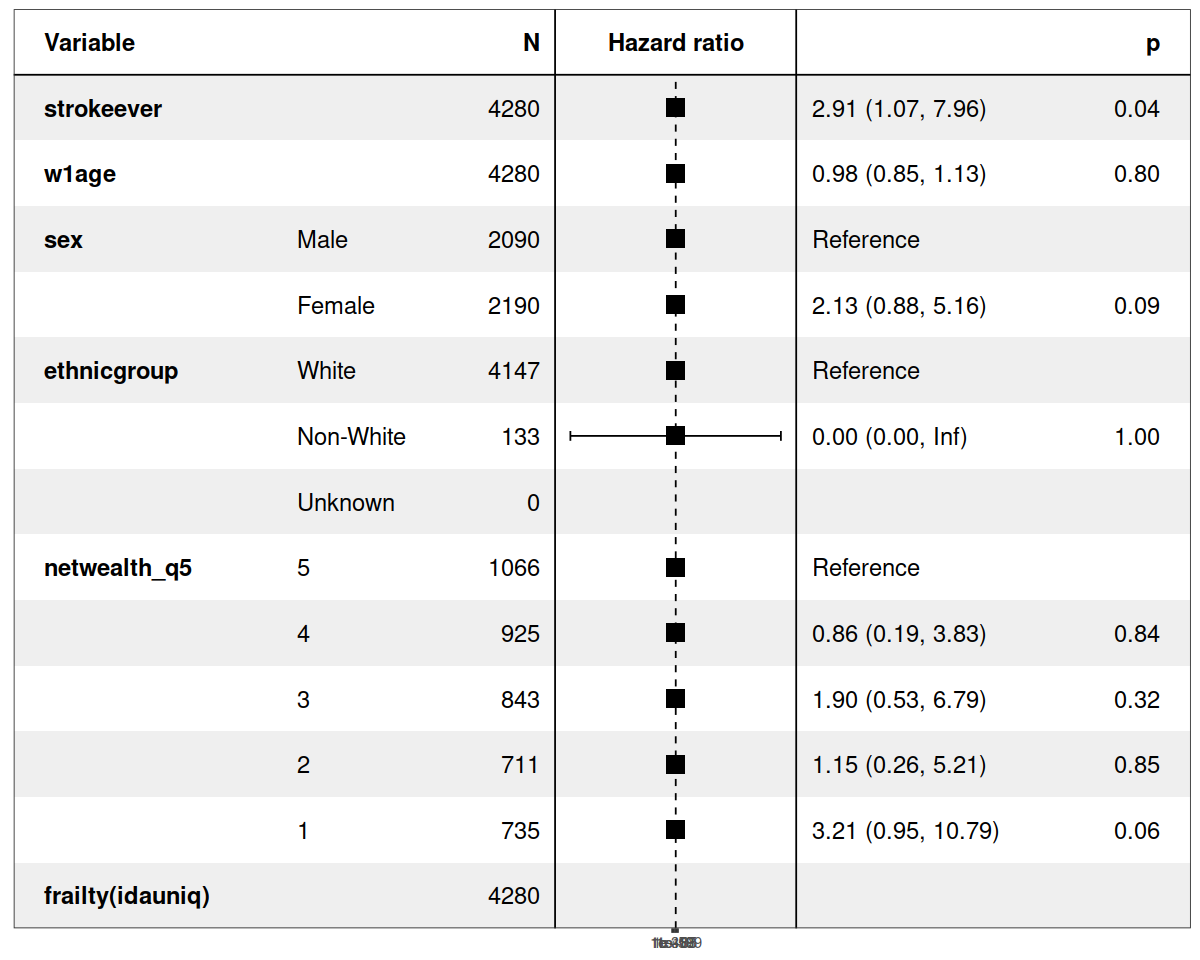

In [80]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputedage60to69)

#### Age 60-69 model 2 (demographic and health behaviour covariates) with imputed data

In [81]:
psychosisinstroke_coxadj2imputedage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_age60to69
)

summary(psychosisinstroke_coxadj2imputedage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_age60to69)

  n= 4280, number of events= 24 

                          coef      se(coef)  se2       Chisq DF    p     
strokeever                  1.03843 5.184e-01 5.135e-01  4.01  1.00 0.0450
w1age                      -0.05651 7.420e-02 7.377e-02  0.58  1.00 0.4500
sexFemale                   0.30360 4.662e-01 4.641e-01  0.42  1.00 0.5100
ethnicgroupNon-White                0.000e+00 0.000e+00        1.00       
ethnicgroupUnknown                  0.000e+00 0.000e+00        1.00       
netwealth_q54              -0.33386 7.707e-01 7.683e-01  0.19  1.00 0.6600
netwealth_q53               0.32717 6.613e-01 6.585e-01  0.24  1.00 0.6200
netwealth_q52              -0.32937 7.881e-01 7.854e-01  0.17  1.00 0.6800
netwealth_q51               0.51367 6.50

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


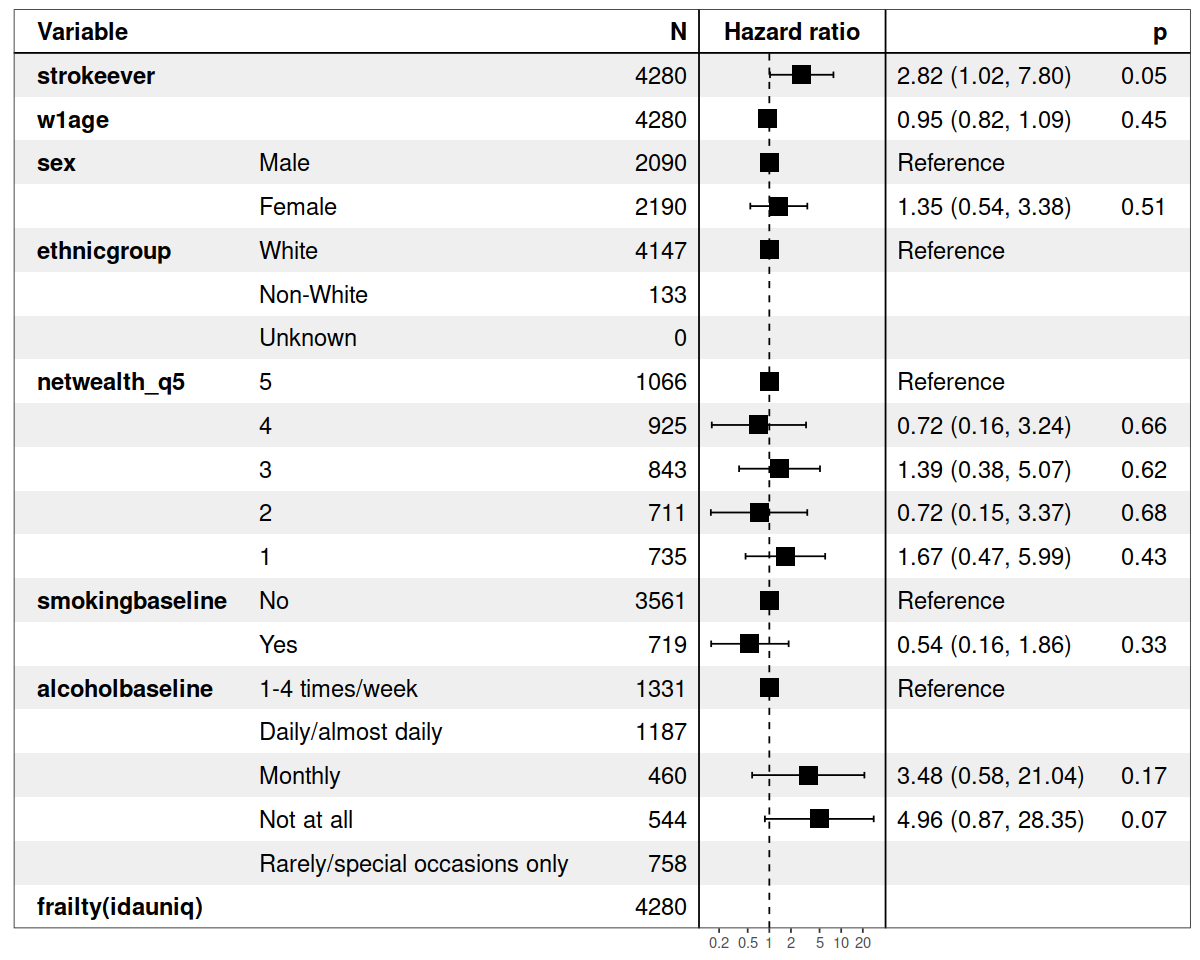

In [82]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2imputedage60to69)

#### Age 70+

In [83]:
psychosisinstroke_imp_age70plus <- psychosisinstroke_imp %>%
  filter(age_cat == "70+")

#### Age 70+ unadjusted with imputed data

In [84]:
# Fit model
psychosisinstroke_coximputedage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_imp_age70plus
)

summary(psychosisinstroke_coximputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_imp_age70plus)

  n= 4061, number of events= 27 

             coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 1.4444    4.2393   0.4052 3.565 0.000364 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     4.239     0.2359     1.916     9.379

Concordance= 0.692  (se = 0.052 )
Likelihood ratio test= 10.7  on 1 df,   p=0.001
Wald test            = 12.71  on 1 df,   p=4e-04
Score (logrank) test = 14.99  on 1 df,   p=1e-04


Resized limits to included dashed line in forest panel



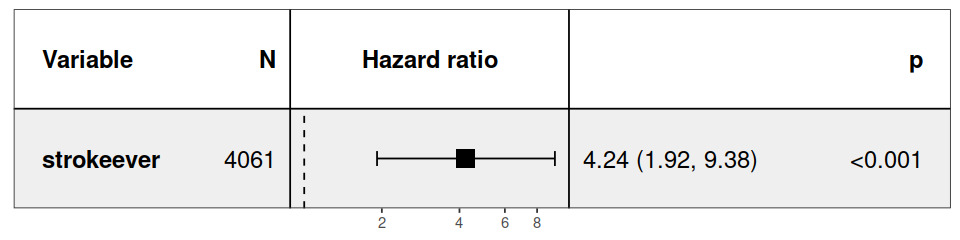

In [85]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_coximputedage70plus)

#### Age 70+ model 1 (demographic covariates) with imputed data

In [86]:
psychosisinstroke_coxadjimputedage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
  data = psychosisinstroke_imp_age70plus
)

summary(psychosisinstroke_coxadjimputedage70plus)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + frailty(idauniq), 
    data = psychosisinstroke_imp_age70plus)

  n= 4061, number of events= 27 

                     coef     se(coef) se2     Chisq  DF   p      
strokeever            2.47691 0.65103  0.54629  14.48    1 0.00014
w1age                 0.01253 0.05261  0.04218   0.06    1 0.81000
sexFemale             0.72640 0.59104  0.47430   1.51    1 0.22000
ethnicgroupNon-White          0.00000  0.00000           1        
ethnicgroupUnknown            0.00000  0.00000           1        
netwealth_q54         0.32059 0.88346  0.67226   0.13    1 0.72000
netwealth_q53        -0.38130 0.89471  0.69064   0.18    1 0.67000
netwealth_q52        -0.11661 0.85287  0.65681   0.02    1 0.89000
netwealth_q51        -0.12432 0.95621  0.74355   0.02    1 0.90000
frailty(idauniq)                               400.09 1251 1.00000

                     exp(coef) exp(-coef

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


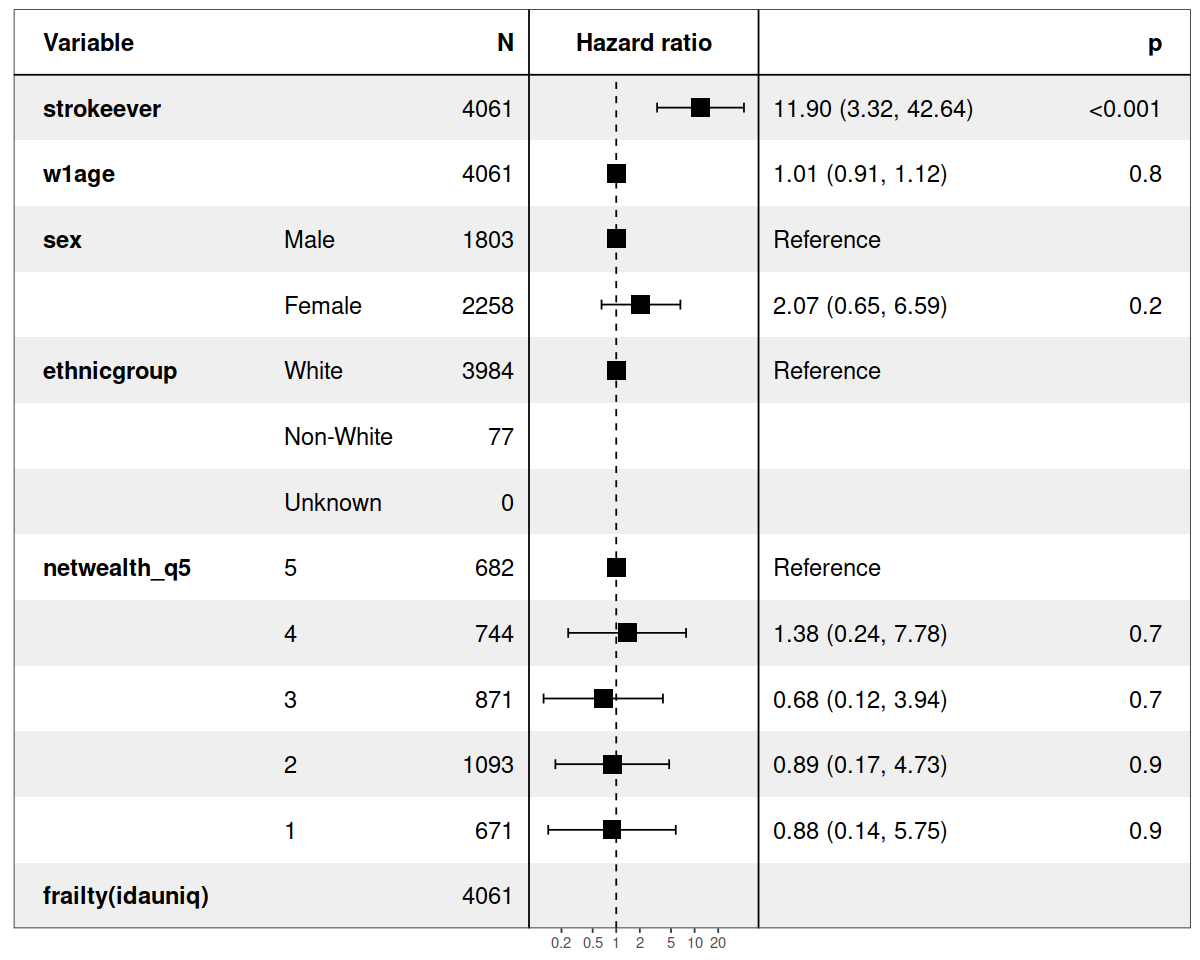

In [87]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadjimputedage70plus)

#### Age 70+ adjusted model 2 (with demographic and health behaviour covariates)

In [88]:
psychosisinstroke_coxadj2imputedage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever + w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
  data = psychosisinstroke_imp_age70plus
)

summary(psychosisinstroke_coxadj2imputedage70plus)

Warning message in coxpenal.fit(X, Y, istrat, offset, init = init, control, weights = weights, :
“Inner loop failed to coverge for iterations 9 10”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”


Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever + 
    w1age + sex + ethnicgroup + netwealth_q5 + smokingbaseline + 
    alcoholbaseline + vigorousactbaseline + frailty(idauniq), 
    data = psychosisinstroke_imp_age70plus)

  n= 4061, number of events= 27 

                          coef      se(coef) se2     Chisq  DF   p      
strokeever                 4.074762 1.0571   0.76884  14.86    1 0.00012
w1age                      0.031392 0.1052   0.05611   0.09    1 0.77000
sexFemale                  0.585807 1.2057   0.54482   0.24    1 0.63000
ethnicgroupNon-White                0.0000   0.00000           1        
ethnicgroupUnknown                  0.0000   0.00000           1        
netwealth_q54              0.003553 1.6445   0.59631   0.00    1 1.00000
netwealth_q53             -0.763930 1.9460             0.15    1 0.69000
netwealth_q52             -1.169257 1.7263             0.46    1 0.50000
netwealth_q51             -2.172254 1.7871   0.95749   1.4

Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


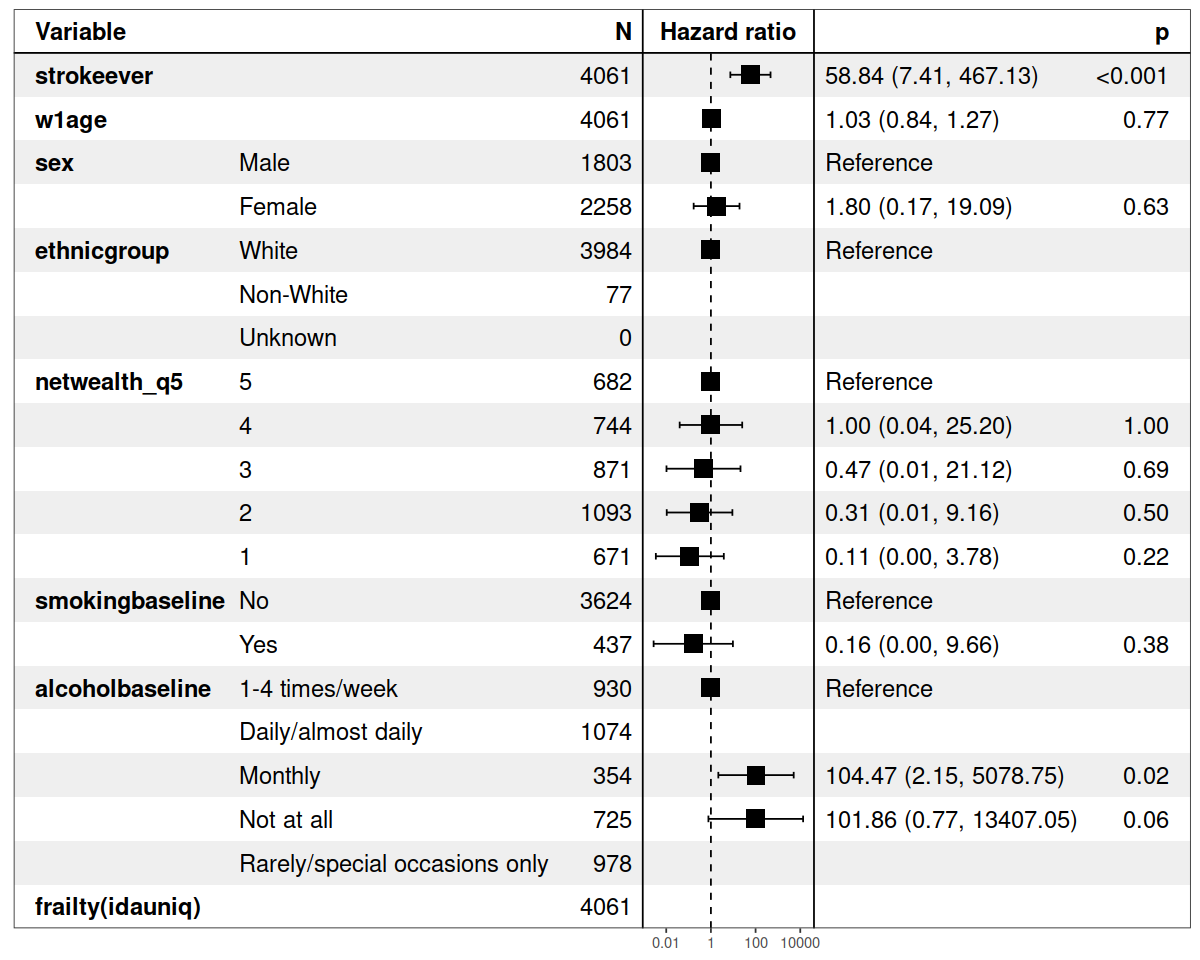

In [89]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2imputedage70plus)

## Analysis platform details and software versions

In [90]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

In [91]:
packageVersion("dplyr")

[1] ‘1.0.9’

In [92]:
packageVersion("survival")

[1] ‘3.2.7’

In [93]:
packageVersion("survminer")

[1] ‘0.4.9’

In [94]:
packageVersion("forestmodel")

[1] ‘0.6.2’

In [95]:
packageVersion("missForest")

[1] ‘1.4’

In [96]:
packageVersion("doParallel")

[1] ‘1.0.17’

In [98]:
packageVersion("doRNG")

[1] ‘1.8.2’